<a href="https://colab.research.google.com/github/Ebrahim-Othman/Predicting-House-Prices-Using-Advanced-Regression/blob/main/Predicting_House_Prices_Using_Advanced_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Machine Learning Approach to Predicting House Prices Using Advanced Regression Techniques


ames-iowa-skyline-color-buildings-isolated-white-backgro-ames-iowa-skyline-color-buildings-isolated-white-101534629.jpg

<a id='intro'></a>
## Introduction
  
Kaggle has launched a competitive competition that aims not so much to get a monetary prize as to help spread the science of machine learning and open many areas of discussion among scientific researchers.
In this competition, we will attempt to arrive at an optimal machine learning model to predict home prices in Ames, Iowa, using various advanced regression techniques.

(Here we analyze the data for The period from 2006 to 2010)

### The Structure Dataset?

> **The data is divided into two groups:**
> - **The training dataset** contains 79 explanatory variables that describe (nearly) every aspect of a residential home, in addition to the **sale price** and **ID** variables. So the total **(81 variables)**
> - **The test dataset** contains 79 explanatory variables that describe (almost) every aspect of residential homes, in addition to **ID**. So the total is **(80 variables)**.
>
> **The target** is to predict the appropriate selling price for each house in the test data.



## Problem description
> The main goal here is to predict the final price of each house for each identifier in the test data set, by predicting the value of the selling price variable, which is not a simple or easy problem due to the multiplicity of features that can affect the test, in addition to the presence of some problems in the data The most important of which are missing values, outliers, and skewness of the distribution for some features.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn_pandas

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


import statistics
from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

SEED = 42     # used to initialize the random number generator.


# visualization
 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
%matplotlib inline

# Define functions

In [2]:
def fillna_all(df):
  for col in list_obj_col:
    df[col].fillna(value=df[col].mode()[0],inplace = True)
  for col in list_num_col:
    df[col].fillna(value=df[col].median(),inplace = True)

In [3]:
def eda_plt (df):
  plt.figure(figsize = (8,5))
  sns.boxplot(x= df)
  plt.show();

In [4]:
def out_lier(df, col):

  first_quartile = df.quantile(0.25)
  third_quartile = df.quantile(0.75)
  IQR= third_quartile - first_quartile
  new_boundary = third_quartile + 3*IQR
  print(f'New boundary Is {new_boundary}')

  median = np.median(df)
  df_train.loc[df > new_boundary, col] = np.nan
  df_train.fillna(median,inplace=True)
  np.median(df)

In [5]:
# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df_train[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [6]:
# Defining scoring function
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

## Upload Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_train=pd.read_csv("/content/drive/MyDrive/UseCase/House Prices/train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/UseCase/House Prices/test.csv")

# Preprocessing Training Data

<a id='wrangling'></a>
## Data Wrangling

> Each data project requires a unique approach to ensuring that its final data set is reliable, accessible, and easier to analyze.

### General Properties

In [9]:
df_train.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
5         Lvl    AllPub  ...        0    NaN  MnPrv        Shed     700   
6         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
7         Lvl    AllPub  ...        0    NaN    NaN        Shed     350   
8         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
9         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  
5     10   2009        WD         Normal     143000  
6      8   2007        WD         Normal     307000  
7     11   2009        WD         Normal     200000  
8      4   2008        WD        Abnorml     129900  
9      1   2008        WD         Normal     118000  

[10 rows x 81 columns]

In [10]:
df_train.shape

(1460, 81)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

> #### Observations from above dataset are:
> <ol>
> Looking at the displayed information that represents the training data for predicting house prices, we notice that there are many data missing for some variables, which require processing or deletion.</li>



## Split Features
### Numerical and Categorical features

In [12]:
list_num_col = list(df_train.select_dtypes(exclude ='object').columns)
print("Number of Numerical features: ", len(list_num_col))

list_obj_col = list(df_train.select_dtypes(include='object').columns)
print("Number of Categorical features: ", len(list_obj_col))

Number of Numerical features:  38
Number of Categorical features:  43


In [13]:
print(f'Numerical features :\n',df_train[list_num_col].columns)
print("*"*100)
print(f'Categorical features :\n',df_train[list_obj_col].columns)

Numerical features :
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
****************************************************************************************************
Categorical features :
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasV

## Data Cleaning
 
> #### Information That We Need To Delete Or Modify
1. Exploring the missing values
2. Handling missing values
3. Check duplicate rows from the dataset
4. Remove the unused colums that are not needes in the analysis process.

#### 1- Exploring the missing values
>- Using a heatmap to quickly identify missing data in each variable, missing data is checked and identified on variables that need to be processed or deleted.

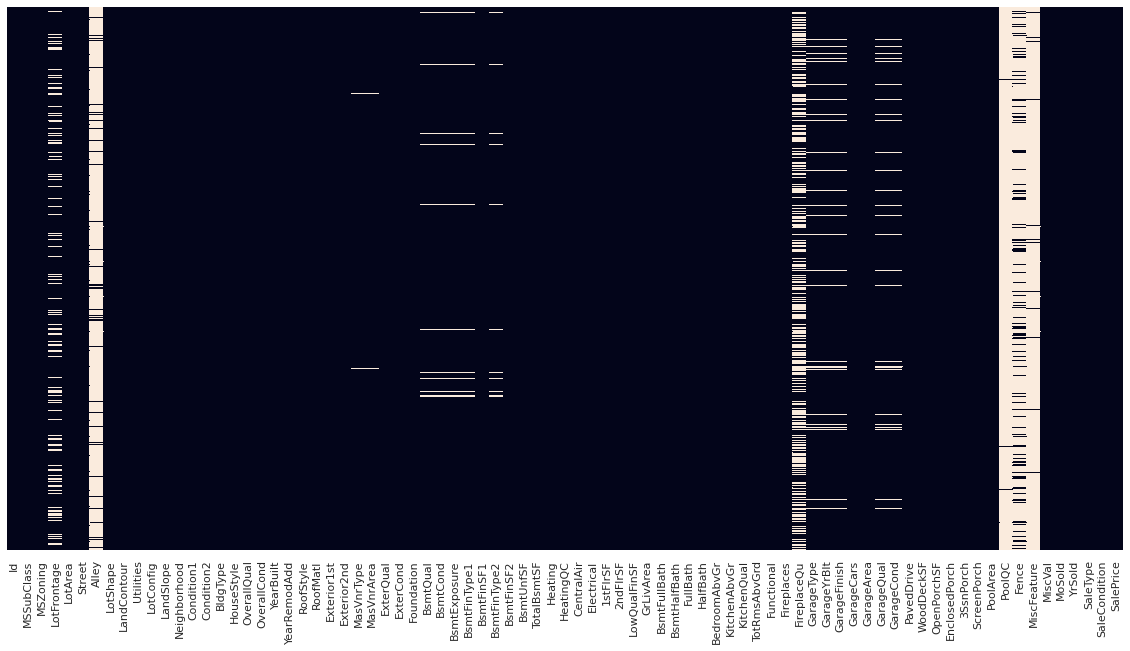

In [14]:
plt.subplots(figsize=(20, 10))
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False);

>- The number of missing data in each variable in the training data

In [15]:
sum(df_train.isna().any())

19

>- We can quantify the missing data in each variable in a more explicit manner using a bar chart.

In [16]:
train_col_nan = df_train.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
train_col_nan[train_col_nan > 0.01].plot(kind = "barh")
#plt.title("Features with the highest percentage of Nan values")

>- It is also possible to indicate the percentages of missing data for each variable.

In [17]:
# See if there are missing values in any of the columns
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Id                0  0.000000

> Observations from above dataset are:
> <ol>
> Each variable (PoolQC, MiscFeature, Alley, Fence) contains approx more than 80% missing data, which means that keeping them will not benefit the analysis with anything. On the contrary, if they are processed and kept, they may lead to misleading results, so we will, in the next step, delete them.</li>

#### 2-  Handling missing values
>  - Drop variables that contain missing values over 80%
>
> - Filling Missing Values with (Mean - Mod).

In [18]:
# Drop variables that contain missing values over 80%

df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

>-  The number of missing data in each variable in the training data After deleting the columns of the variables (PoolQC, MiscFeature, Alley, Fence), Because they contain more than 80% missing data.

In [19]:
train_col_nan = df_train.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
train_col_nan[train_col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

>- The number of missing data in each variable in the training data

In [20]:
sum(df_train.isna().any())

15

> - Filling Missing Values with (Mean - Mod) according to the variable type
 

In [21]:
list_obj_col = list(df_train.select_dtypes(include='object').columns)

In [22]:
list_num_col = list(df_train.select_dtypes(exclude ='object').columns)

In [23]:
fillna_all(df_train)

In [24]:
df_train.shape

(1460, 77)

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [26]:
# data description
df_train.describe().round(2)

Id  MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  \
count  1460.00      1460.0      1460.00    1460.00      1460.00      1460.00   
mean    730.50        56.9        69.86   10516.83         6.10         5.58   
std     421.61        42.3        22.03    9981.26         1.38         1.11   
min       1.00        20.0        21.00    1300.00         1.00         1.00   
25%     365.75        20.0        60.00    7553.50         5.00         5.00   
50%     730.50        50.0        69.00    9478.50         6.00         5.00   
75%    1095.25        70.0        79.00   11601.50         7.00         6.00   
max    1460.00       190.0       313.00  215245.00        10.00         9.00   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  \
count    1460.00       1460.00     1460.00     1460.00  ...     1460.00   
mean     1971.27       1984.87      103.12      443.64  ...       94.24   
std        30.20         20.65      180.73      456.10  ...      125.34   
min      1872.00       1950.00        0.00        0.00  ...        0.00   
25%      1954.00       1967.00        0.00        0.00  ...        0.00   
50%      1973.00       1994.00        0.00      383.50  ...        0.00   
75%      2000.00       2004.00      164.25      712.25  ...      168.00   
max      2010.00       2010.00     1600.00     5644.00  ...      857.00   

       OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal  \
count      1460.00        1460.00    1460.00      1460.00   1460.00   1460.00   
mean         46.66          21.95       3.41        15.06      2.76     43.49   
std          66.26          61.12      29.32        55.76     40.18    496.12   
min           0.00           0.00       0.00         0.00      0.00      0.00   
25%           0.00           0.00       0.00         0.00      0.00      0.00   
50%          25.00           0.00       0.00         0.00      0.00      0.00   
75%          68.00           0.00       0.00         0.00      0.00      0.00   
max         547.00         552.00     508.00       480.00    738.00  15500.00   

        MoSold   YrSold  SalePrice  
count  1460.00  1460.00     1460.0  
mean      6.32  2007.82   180921.2  
std       2.70     1.33    79442.5  
min       1.00  2006.00    34900.0  
25%       5.00  2007.00   129975.0  
50%       6.00  2008.00   163000.0  
75%       8.00  2009.00   214000.0  
max      12.00  2010.00   755000.0  

[8 rows x 38 columns]

#### 3. Check duplicate rows from the dataset

In [27]:
print(df_train.duplicated(keep=False).sum())

0


#### 4. Remove the unused colums that are not needes in the analysis process.

In [28]:
# Dropping ID column for train dataset
df_train.drop(['Id'], axis=1, inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis

>Through approximately 79 variables that are supposed to have an impact on the selling price of the house, we will focus here on examining the relationship of these variables with the selling price variable by asking and answering many questions using mathematical and statistical operations, and creating visualizations aimed at addressing the research questions we raised in the introduction section.

### Exploring the relationship between Numerical features and the seleprice
> Here we are interested in knowing the shape of the data distribution and whether there is a correlation between the sale price and the numerical variables.

#### Correlation

In [29]:
# Here we use the corr() function  to show the relationship between the variables
# and sns.heatmap to graphically represent the relationship

plt.figure(figsize=(40,20))
sns.heatmap(df_train.corr(), cmap = 'coolwarm', annot = True)
df_train.corr()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
MSSubClass       1.000000    -0.356718 -0.139781     0.032628    -0.059316   
LotFrontage     -0.356718     1.000000  0.304522     0.234812    -0.053281   
LotArea         -0.139781     0.304522  1.000000     0.105806    -0.005636   
OverallQual      0.032628     0.234812  0.105806     1.000000    -0.091932   
OverallCond     -0.059316    -0.053281 -0.005636    -0.091932     1.000000   
YearBuilt        0.027850     0.116685  0.014228     0.572323    -0.375983   
YearRemodAdd     0.040581     0.083348  0.013788     0.550684     0.073741   
MasVnrArea       0.023573     0.178469  0.103321     0.407252    -0.125694   
BsmtFinSF1      -0.069836     0.214367  0.214103     0.239666    -0.046231   
BsmtFinSF2      -0.065649     0.042463  0.111170    -0.059119     0.040229   
BsmtUnfSF       -0.140759     0.124098 -0.002618     0.308159    -0.136841   
TotalBsmtSF     -0.238518     0.363472  0.260833     0.537808    -0.171098   
1stFlrSF        -0.251758     0.413773  0.299475     0.476224    -0.144203   
2ndFlrSF         0.307886     0.072388  0.050986     0.295493     0.028942   
LowQualFinSF     0.046474     0.037469  0.004779    -0.030429     0.025494   
GrLivArea        0.074853     0.368007  0.263116     0.593007    -0.079686   
BsmtFullBath     0.003491     0.090343  0.158155     0.111098    -0.054942   
BsmtHalfBath    -0.002333    -0.006979  0.048046    -0.040150     0.117821   
FullBath         0.131608     0.180534  0.126031     0.550600    -0.194149   
HalfBath         0.177354     0.047222  0.014259     0.273458    -0.060769   
BedroomAbvGr    -0.023438     0.236840  0.119690     0.101676     0.012980   
KitchenAbvGr     0.281721    -0.004905 -0.017784    -0.183882    -0.087001   
TotRmsAbvGrd     0.040380     0.320518  0.190015     0.427452    -0.057583   
Fireplaces      -0.045569     0.233221  0.271364     0.396765    -0.023820   
GarageYrBlt      0.081396     0.062996 -0.025865     0.514231    -0.306276   
GarageCars      -0.040110     0.269539  0.154871     0.600671    -0.185758   
GarageArea      -0.098672     0.323511  0.180403     0.562022    -0.151521   
WoodDeckSF      -0.012579     0.075542  0.171698     0.238923    -0.003334   
OpenPorchSF     -0.006100     0.137014  0.084774     0.308819    -0.032589   
EnclosedPorch   -0.012037     0.010287 -0.018340    -0.113937     0.070356   
3SsnPorch       -0.043825     0.061945  0.020423     0.030371     0.025504   
ScreenPorch     -0.026030     0.037655  0.043160     0.064886     0.054811   
PoolArea         0.008283     0.180819  0.077672     0.065166    -0.001985   
MiscVal         -0.007683    -0.000255  0.038068    -0.031406     0.068777   
MoSold          -0.013585     0.010451  0.001205     0.070815    -0.003511   
YrSold          -0.021407     0.006380 -0.014261    -0.027347     0.043950   
SalePrice       -0.084284     0.334771  0.263843     0.790982    -0.077856   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
MSSubClass      0.027850      0.040581    0.023573   -0.069836   -0.065649   
LotFrontage     0.116685      0.083348    0.178469    0.214367    0.042463   
LotArea         0.014228      0.013788    0.103321    0.214103    0.111170   
OverallQual     0.572323      0.550684    0.407252    0.239666   -0.059119   
OverallCond    -0.375983      0.073741   -0.125694   -0.046231    0.040229   
YearBuilt       1.000000      0.592855    0.311600    0.249503   -0.049107   
YearRemodAdd    0.592855      1.000000    0.176529    0.128451   -0.067759   
MasVnrArea      0.311600      0.176529    1.000000    0.261256   -0.071330   
BsmtFinSF1      0.249503      0.128451    0.261256    1.000000   -0.050117   
BsmtFinSF2     -0.049107     -0.067759   -0.071330   -0.050117    1.000000   
BsmtUnfSF       0.149040      0.181133    0.113862   -0.495251   -0.209294   
TotalBsmtSF     0.391452      0.291066    0.360067    0.522396    0.104810   
1stFlrSF        0.281986      0.2403

In [30]:
correlation = df_train.corr()
print(correlation['SalePrice'].sort_values(ascending = False),'\n' )

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64 



OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  TotalBsmtSF  \
OverallQual      1.000000   0.572323      0.550684    0.407252     0.537808   
YearBuilt        0.572323   1.000000      0.592855    0.311600     0.391452   
YearRemodAdd     0.550684   0.592855      1.000000    0.176529     0.291066   
MasVnrArea       0.407252   0.311600      0.176529    1.000000     0.360067   
TotalBsmtSF      0.537808   0.391452      0.291066    0.360067     1.000000   
1stFlrSF         0.476224   0.281986      0.240379    0.339850     0.819530   
GrLivArea        0.593007   0.199010      0.287389    0.388052     0.454868   
FullBath         0.550600   0.468271      0.439046    0.272999     0.323722   
TotRmsAbvGrd     0.427452   0.095589      0.191740    0.279568     0.285573   
Fireplaces       0.396765   0.147716      0.112581    0.247015     0.339519   
GarageYrBlt      0.514231   0.777182      0.616444    0.244444     0.309386   
GarageCars       0.600671   0.537850      0.420622    0.361945     0.434585   
GarageArea       0.562022   0.478954      0.371600    0.370884     0.486665   
SalePrice        0.790982   0.522897      0.507101    0.472614     0.613581   

              1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  Fireplaces  \
OverallQual   0.476224   0.593007  0.550600      0.427452    0.396765   
YearBuilt     0.281986   0.199010  0.468271      0.095589    0.147716   
YearRemodAdd  0.240379   0.287389  0.439046      0.191740    0.112581   
MasVnrArea    0.339850   0.388052  0.272999      0.279568    0.247015   
TotalBsmtSF   0.819530   0.454868  0.323722      0.285573    0.339519   
1stFlrSF      1.000000   0.566024  0.380637      0.409516    0.410531   
GrLivArea     0.566024   1.000000  0.630012      0.825489    0.461679   
FullBath      0.380637   0.630012  1.000000      0.554784    0.243671   
TotRmsAbvGrd  0.409516   0.825489  0.554784      1.000000    0.326114   
Fireplaces    0.410531   0.461679  0.243671      0.326114    1.000000   
GarageYrBlt   0.224897   0.219801  0.466809      0.139519    0.042967   
GarageCars    0.439317   0.467247  0.469672      0.362289    0.300789   
GarageArea    0.489782   0.468997  0.405656      0.337822    0.269141   
SalePrice     0.605852   0.708624  0.560664      0.533723    0.466929   

              GarageYrBlt  GarageCars  GarageArea  SalePrice  
OverallQual      0.514231    0.600671    0.562022   0.790982  
YearBuilt        0.777182    0.537850    0.478954   0.522897  
YearRemodAdd     0.616444    0.420622    0.371600   0.507101  
MasVnrArea       0.244444    0.361945    0.370884   0.472614  
TotalBsmtSF      0.309386    0.434585    0.486665   0.613581  
1stFlrSF         0.224897    0.439317    0.489782   0.605852  
GrLivArea        0.219801    0.467247    0.468997   0.708624  
FullBath         0.466809    0.469672    0.405656   0.560664  
TotRmsAbvGrd     0.139519    0.362289    0.337822   0.533723  
Fireplaces       0.042967    0.300789    0.269141   0.466929  
GarageYrBlt      1.000000    0.474313    0.468804   0.466754  
GarageCars       0.474313    1.000000    0.882475   0.640409  
GarageArea       0.468804    0.882475    1.000000   0.623431  
SalePrice        0.466754    0.640409    0.623431   1.000000

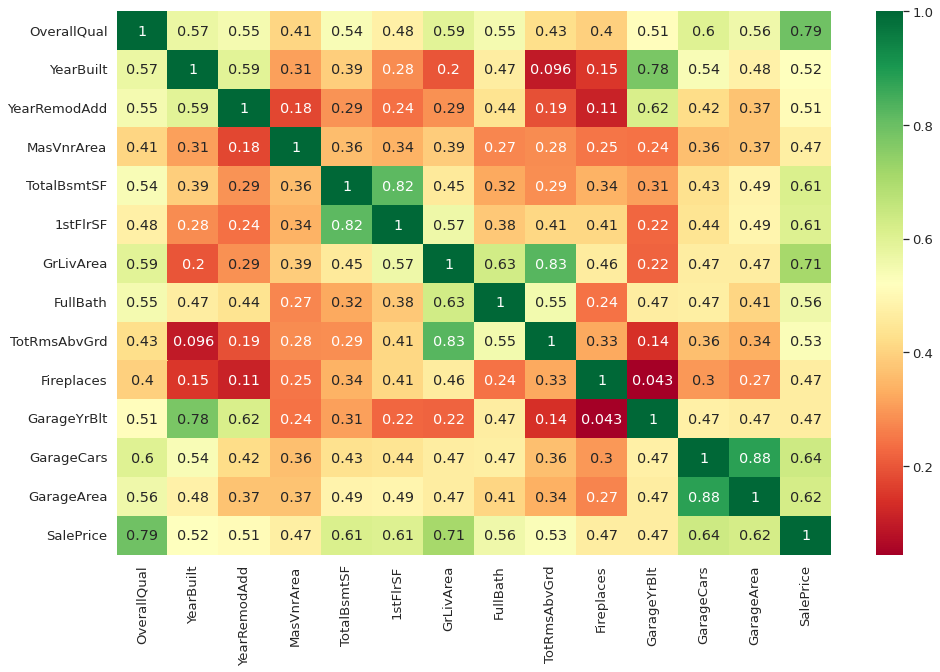

In [31]:
corrmat = df_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.4]
plt.figure(figsize=(16,10))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
df_train[top_corr_features].corr()

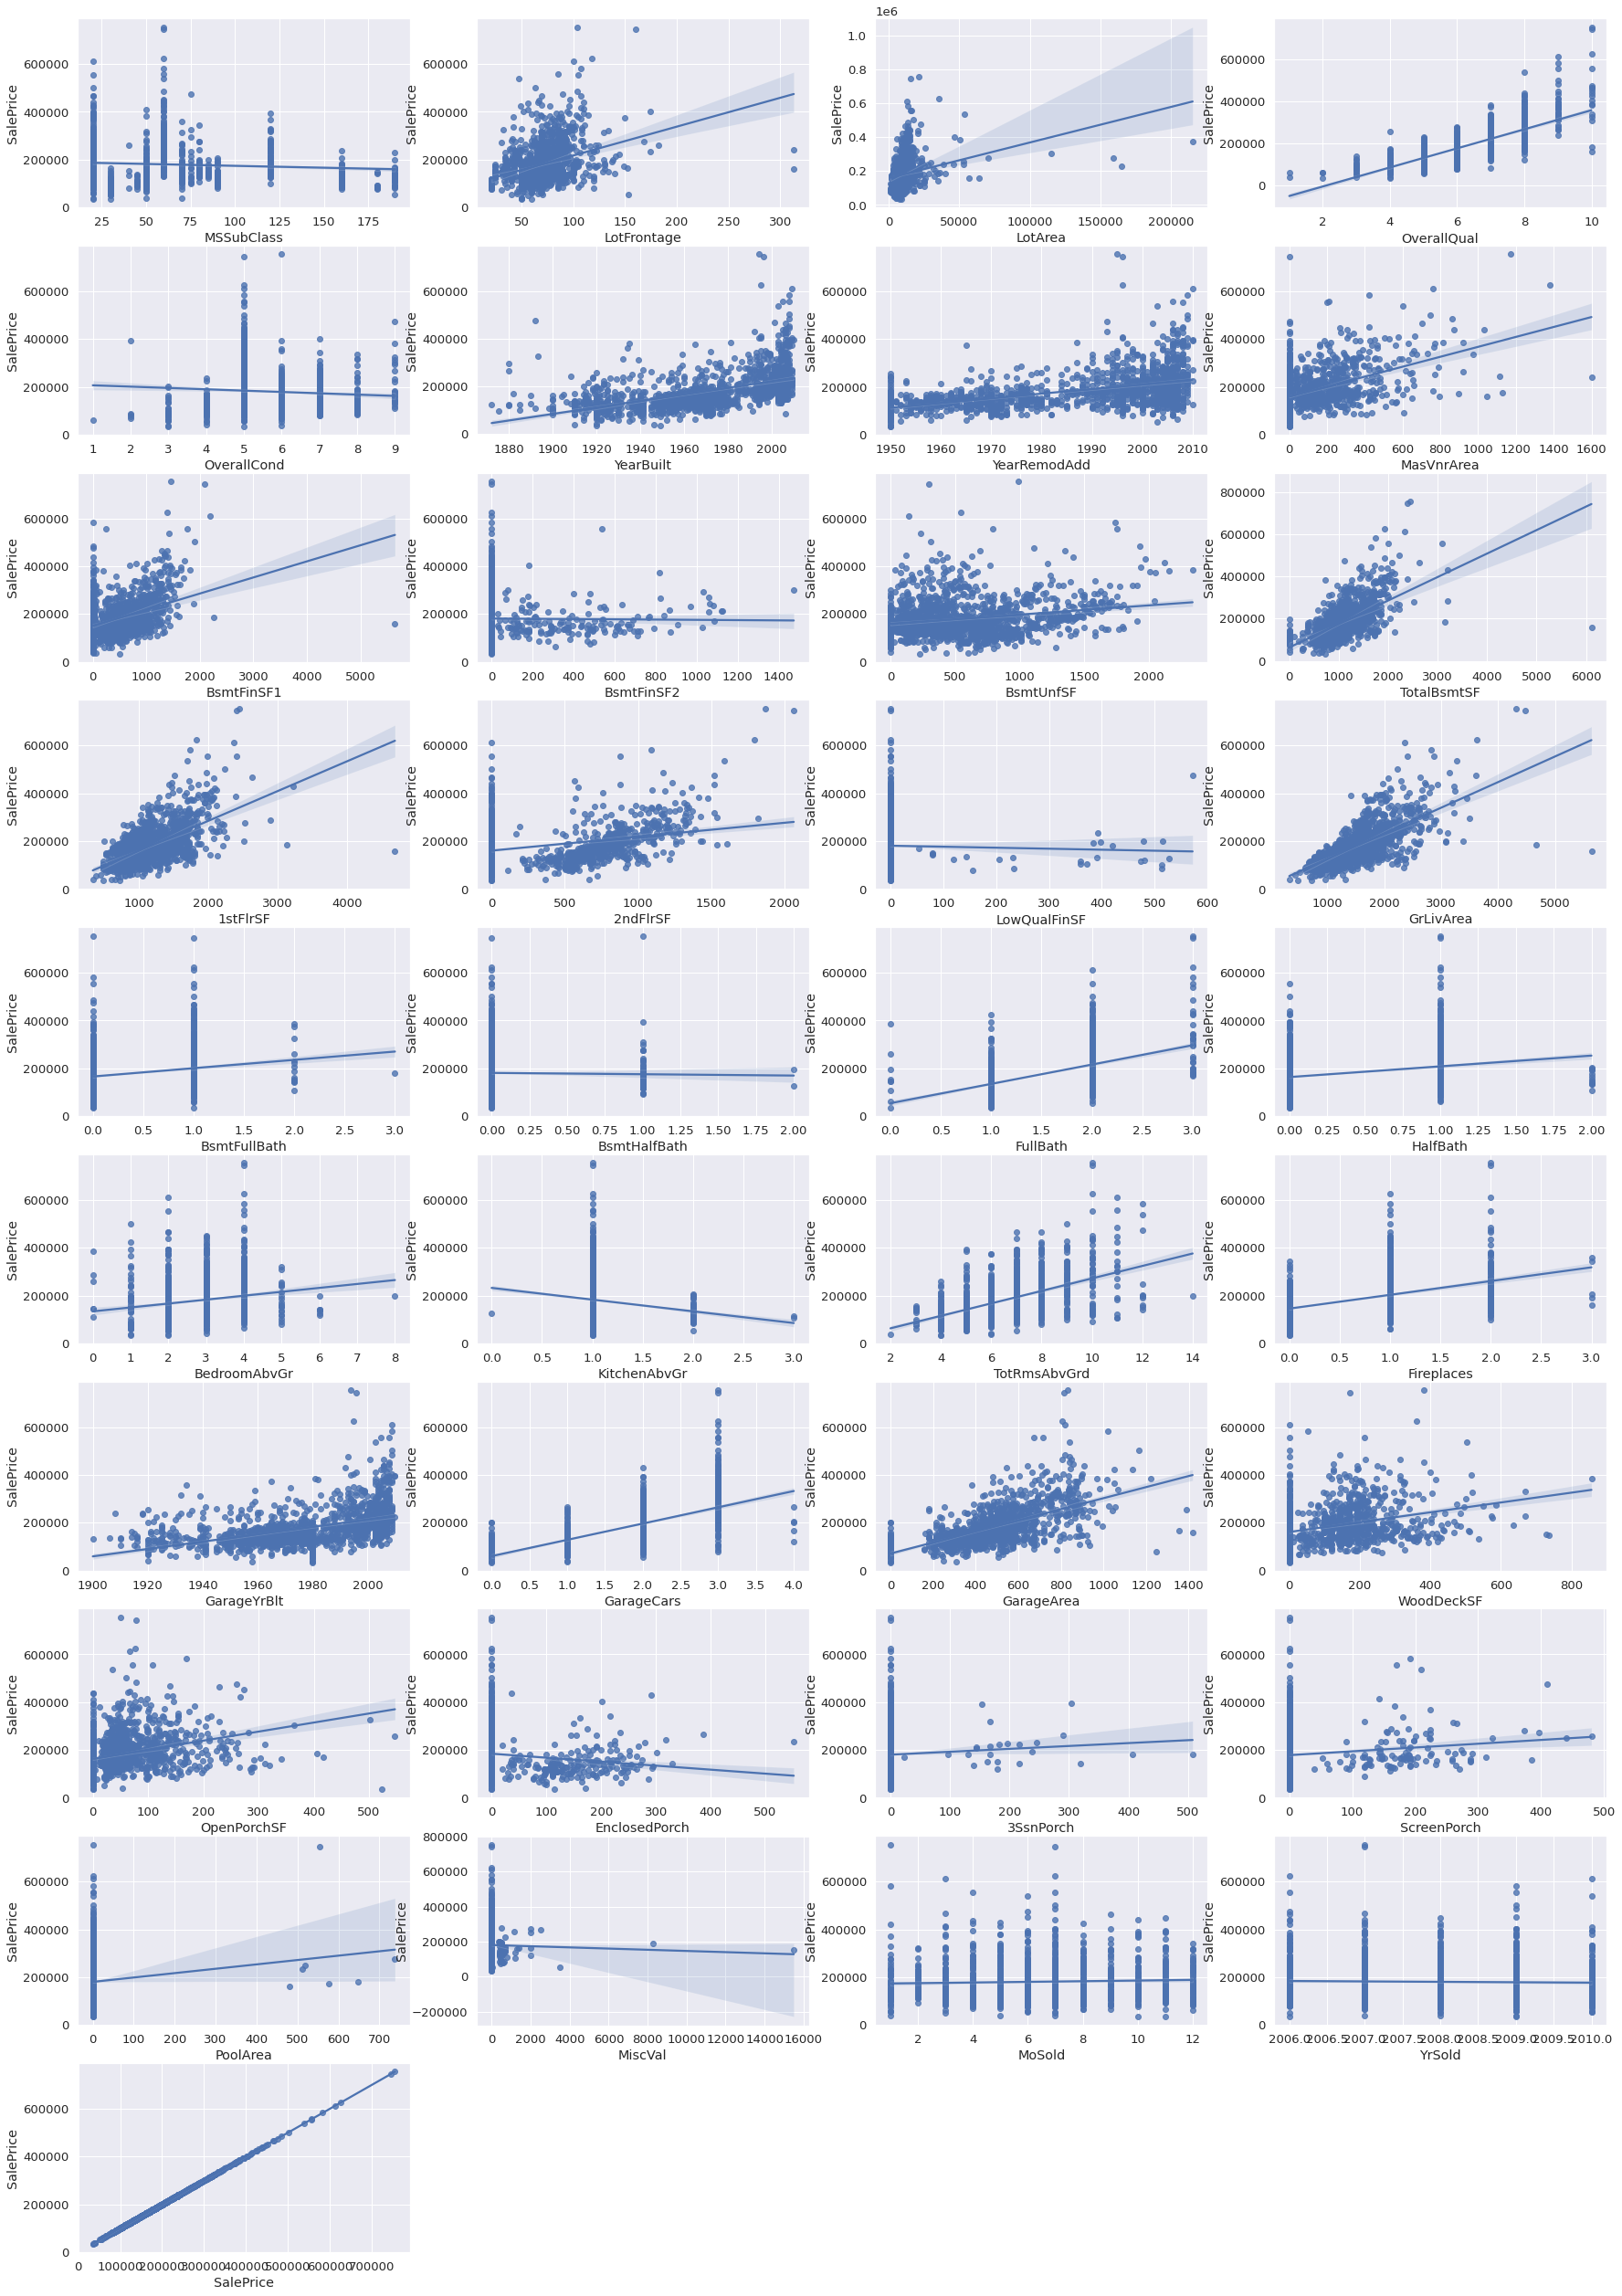

In [32]:
X = df_train.copy()
y = X.pop("SalePrice")


plt.figure(figsize = (30,45))
i = 1
rows = len(df_train.corr()) // 4 + 1
for feature in df_train.corr():
    ax = plt.subplot(rows,4,i)
    sns.regplot(x=feature, y="SalePrice", data=df_train,ax=ax)
    i+=1

> Observations from above dataset are:
> <ol>
> With a first look at the form of the relationship and the distribution and spread of data between the numerical variables and the selling price variable, we find that it is divided into: 
>
> - Defective variables:
>>
>> In these variables, we notice a clear correlation between them and the selling price variable, but we also notice a deviation in the form of data distribution so that most of the data is concentrated in one aspect, which makes this relationship defective.
>>
>>Reason: 
>>
>>The existence of outliers that could have an impact on this relationship
>>
>>Required treatment:
>> 
>> Process outliers by deleting them or by processing them with an interquartile range (IQR).
>>
>>Variable names: 
>>
>>(LotArea - MasVnrArea - BsmtFinSF1 - TotalBsmtSF - OpenPorchSF)


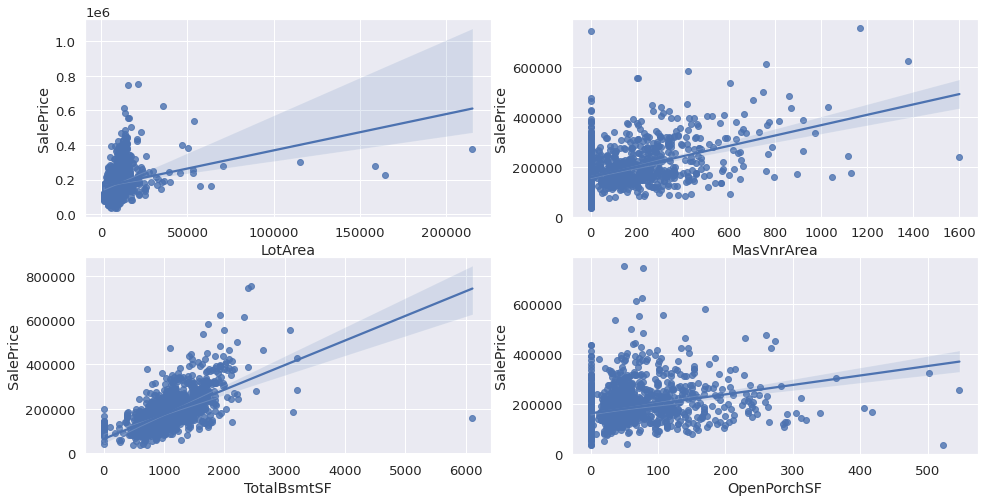

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

#fig.suptitle('Defective variables')

sns.regplot(ax=axes[0, 0], data=df_train, x='LotArea', y='SalePrice')
sns.regplot(ax=axes[0, 1], data=df_train, x='MasVnrArea', y='SalePrice')
sns.regplot(ax=axes[1, 0], data=df_train, x='TotalBsmtSF', y='SalePrice')
sns.regplot(ax=axes[1, 1], data=df_train, x='OpenPorchSF', y='SalePrice')

> - Strong Relationship:
>>
>> With regard to these variables, we find that the relationship between them and the selling price variable is strong, and the shape of the data distribution is good and very close to the normal shape, but there are also some outliers that may have an effect on this correlation.
>>
>>Required treatment: 
>>
>> Process outliers by deleting them or by processing them with an interquartile range (IQR).
>>
>>Variable names: 
>>
>>(GrLivArea- GarageArea - GarageYrBlt - YearBuilt - YearRemodAdd - WoodDeckSF - BsmtUnfSFt)

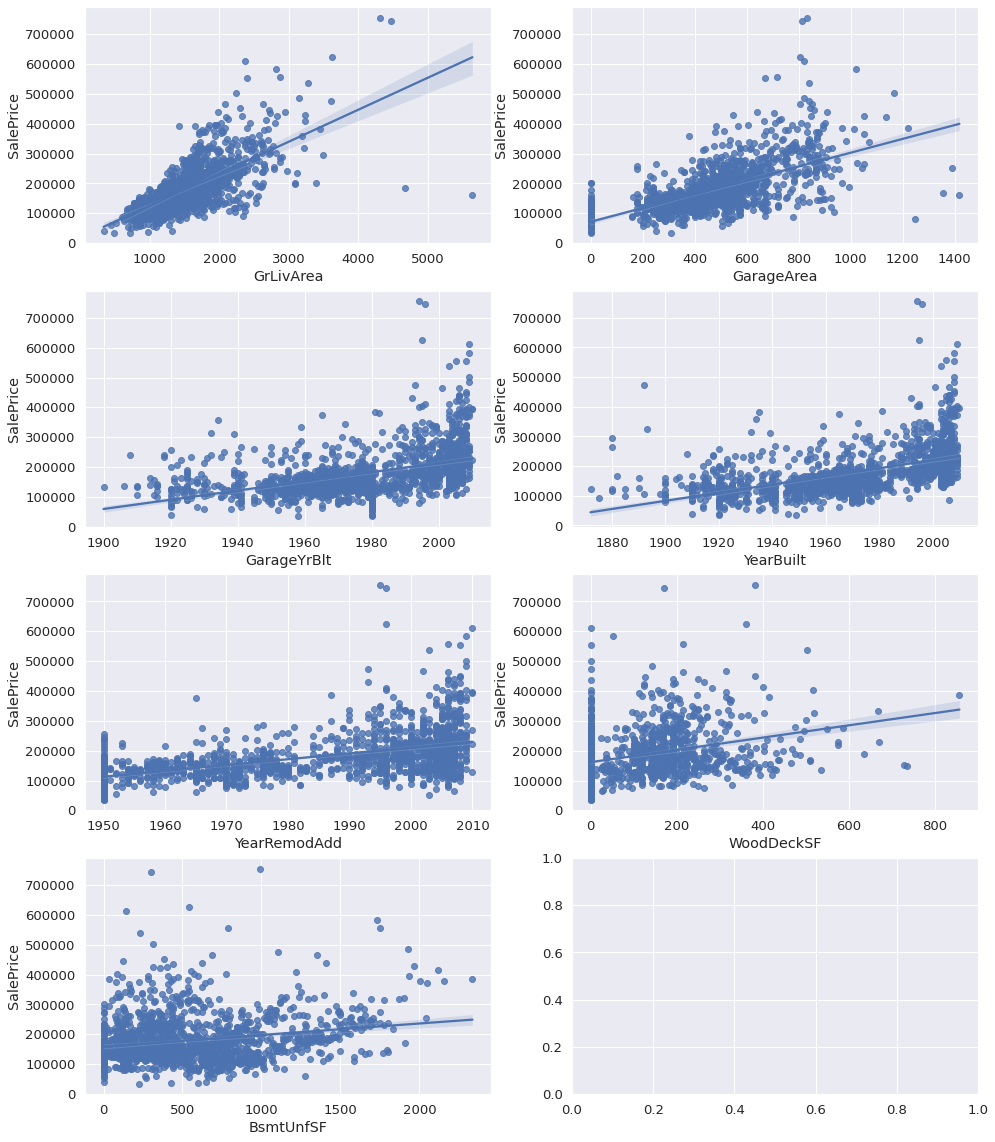

In [34]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

#fig.suptitle('Strong Relationship')

sns.regplot(ax=axes[0, 0], data=df_train, x='GrLivArea', y='SalePrice')
sns.regplot(ax=axes[0, 1], data=df_train, x='GarageArea', y='SalePrice')
sns.regplot(ax=axes[1, 0], data=df_train, x='GarageYrBlt', y='SalePrice')
sns.regplot(ax=axes[1, 1], data=df_train, x='YearBuilt', y='SalePrice')
sns.regplot(ax=axes[2, 0], data=df_train, x='YearRemodAdd', y='SalePrice')
sns.regplot(ax=axes[2, 1], data=df_train, x='WoodDeckSF', y='SalePrice')
sns.regplot(ax=axes[3, 0], data=df_train, x='BsmtUnfSF', y='SalePrice')

> - Separate variables with a strong relationship and influence:
>>
>> We note here that there is a strong and influential relationship between each of these variables and the selling price variable, but what is new here is that although these variables are numeric, they are represented in the form of categorical variables.
>>
>>Reason: 
>>
>>The values of these variables are discrete values.
>>
>>Here we have an important note: 
>>
>> That each unit increase in the discrete variable indicates the same amount of increase in the variable we want to measure (sale price). As long as this is true, the regression coefficient for that independent variable will make sense, because you can legitimately interpret it as the slope of the regression line.
>>
>>Variable names: 
>>
>>(OverallQual - FullBath - TotRmsAbvGrd - BsmtFullBath - HalfBath - BedroomAbvGr - KitchenAbvGr - Fireplaces - GarageCars)

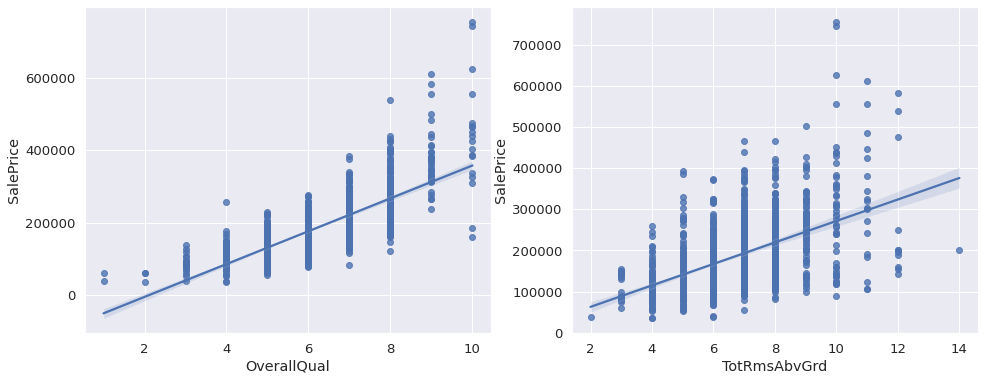

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#fig.suptitle('Separate Relationship')

sns.regplot(ax=axes[0], data=df_train, x='OverallQual', y='SalePrice')
sns.regplot(ax=axes[1], data=df_train, x='TotRmsAbvGrd', y='SalePrice')

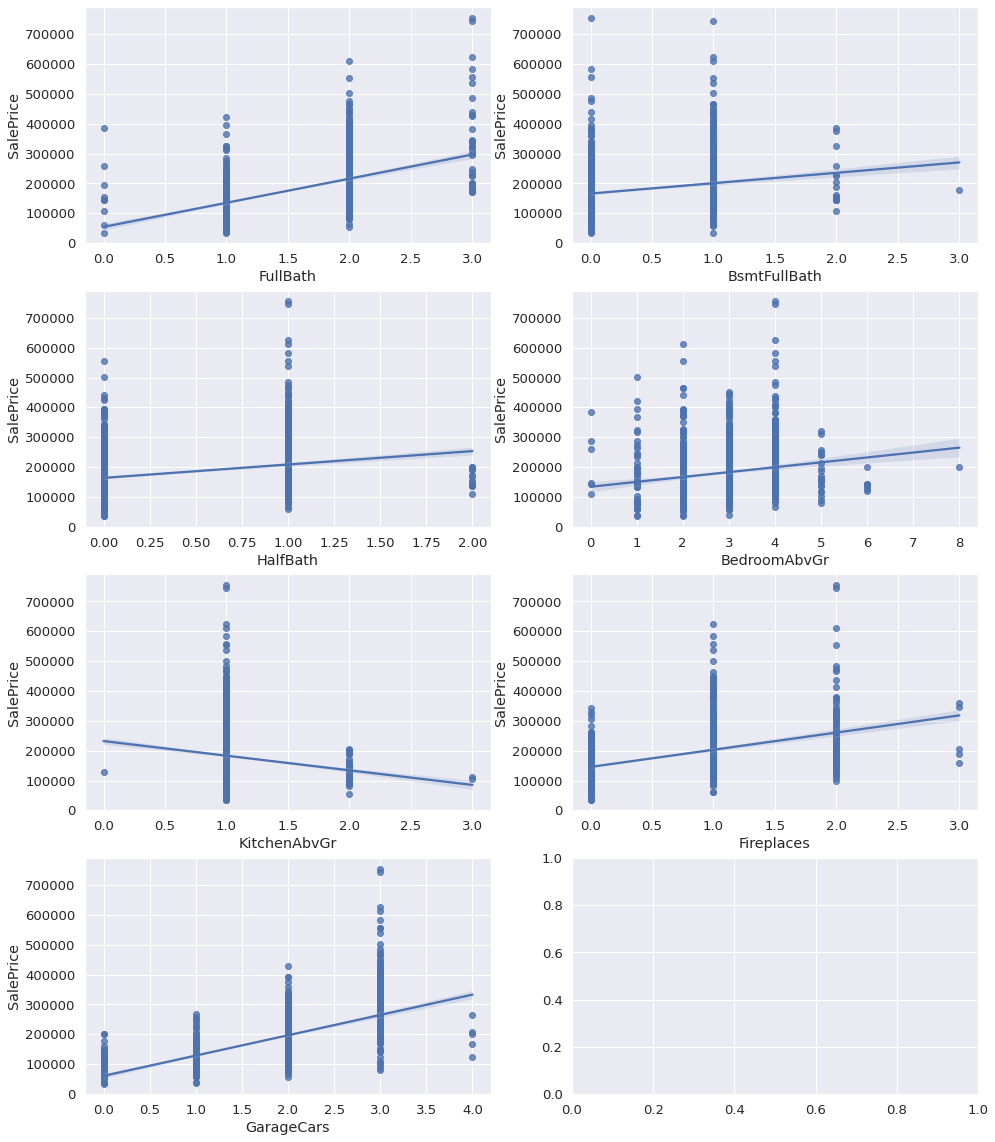

In [36]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

#fig.suptitle('Weak Relationship')

sns.regplot(ax=axes[0, 0], data=df_train, x='FullBath', y='SalePrice')
sns.regplot(ax=axes[0, 1], data=df_train, x='BsmtFullBath', y='SalePrice')
sns.regplot(ax=axes[1, 0], data=df_train, x='HalfBath', y='SalePrice')
sns.regplot(ax=axes[1, 1], data=df_train, x='BedroomAbvGr', y='SalePrice')
sns.regplot(ax=axes[2, 0], data=df_train, x='KitchenAbvGr', y='SalePrice')
sns.regplot(ax=axes[2, 1], data=df_train, x='Fireplaces', y='SalePrice')
sns.regplot(ax=axes[3, 0], data=df_train, x='GarageCars', y='SalePrice')

> - Weak and stable relationship at a certain limit:
>>
>> Where we find in this set of variables that the relationship between them and the selling price variable is constant, no matter what happens in these variables.
>>
>>
>>Required treatment: 
>> We wait for the degree of correlation to be measured.
>>
>>Variable names: 
>>
>>(YrSold - MSSubClass - BsmtHalfBath - MoSold - LowQualFinSF - MiscVal - PoolArea - ScreenPorch - 3SsnPorch - EnclosedPorch)


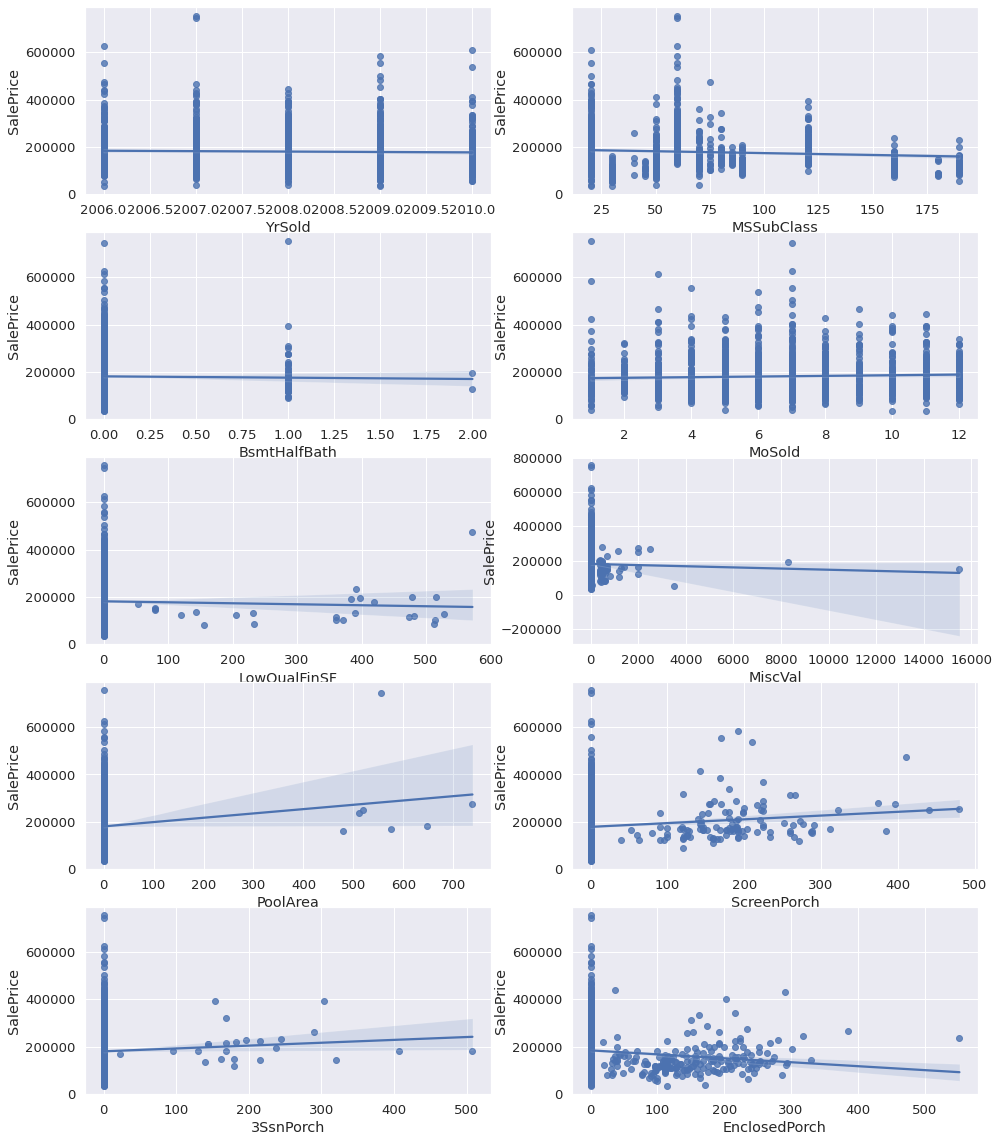

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(16, 20))

#fig.suptitle('Weak and stable relationship at a certain limit')

sns.regplot(ax=axes[0, 0], data=df_train, x='YrSold', y='SalePrice')
sns.regplot(ax=axes[0, 1], data=df_train, x='MSSubClass', y='SalePrice')
sns.regplot(ax=axes[1, 0], data=df_train, x='BsmtHalfBath', y='SalePrice')
sns.regplot(ax=axes[1, 1], data=df_train, x='MoSold', y='SalePrice')
sns.regplot(ax=axes[2, 0], data=df_train, x='LowQualFinSF', y='SalePrice')
sns.regplot(ax=axes[2, 1], data=df_train, x='MiscVal', y='SalePrice')
sns.regplot(ax=axes[3, 0], data=df_train, x='PoolArea', y='SalePrice')
sns.regplot(ax=axes[3, 1], data=df_train, x='ScreenPorch', y='SalePrice')
sns.regplot(ax=axes[4, 0], data=df_train, x='3SsnPorch', y='SalePrice')
sns.regplot(ax=axes[4, 1], data=df_train, x='EnclosedPorch', y='SalePrice')

####  Categorical Features
> The relationship between selling price and categorical Features

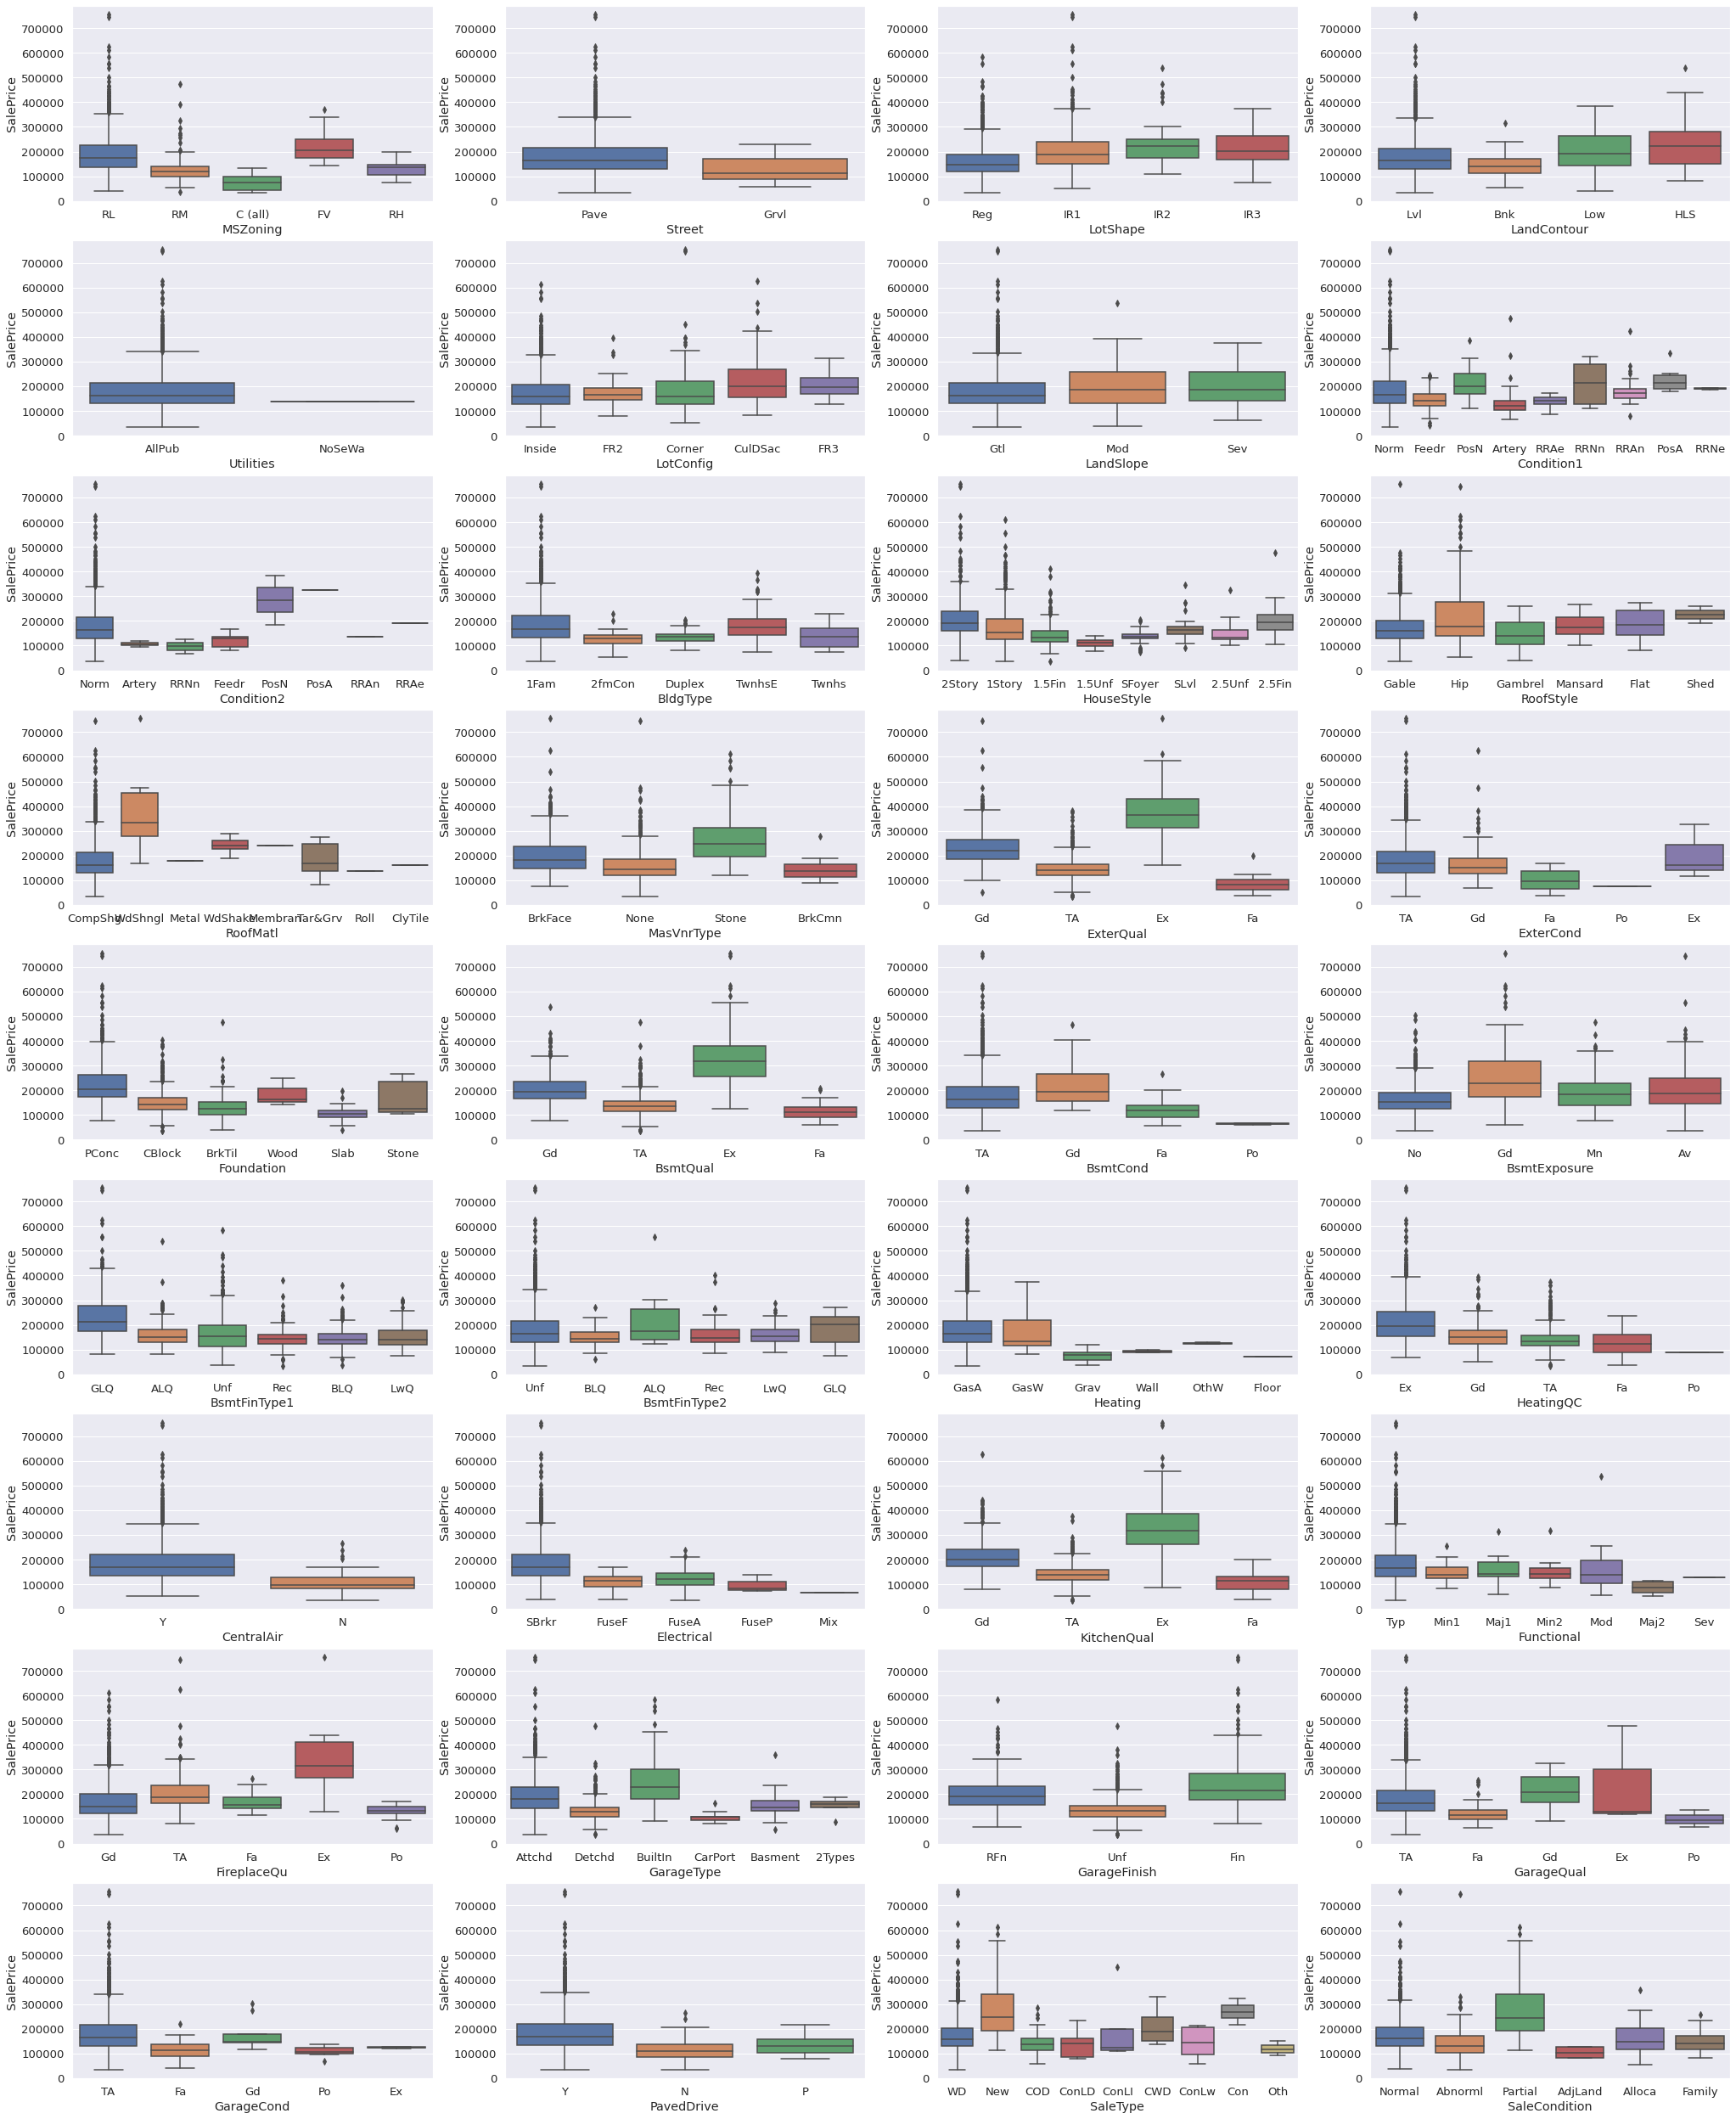

In [38]:
list_obj_col.remove('Neighborhood')
list_obj_col.remove('Exterior1st')
list_obj_col.remove('Exterior2nd')

cat_feats = list(list_obj_col)



X = df_train.copy()
y = X.pop("SalePrice")


plt.figure(figsize = (35,50))
i = 1
rows = len(cat_feats) // 4 + 1
for feature in cat_feats:
    ax = plt.subplot(rows,4,i)
    sns.boxplot(x=feature, y="SalePrice", data=df_train,ax=ax)
    i+=1

In [39]:
list_obj_col = list(df_train.select_dtypes(include='object').columns)

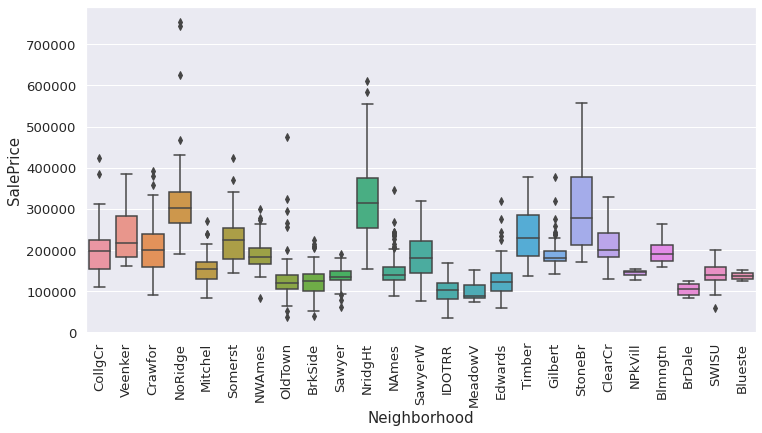

In [40]:
plt.figure(figsize=(12,6))
sns.boxplot(x= 'Neighborhood', y="SalePrice", data=df_train)
#plt.title('Neighborhood Vs SalePrice', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('SalePrice', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

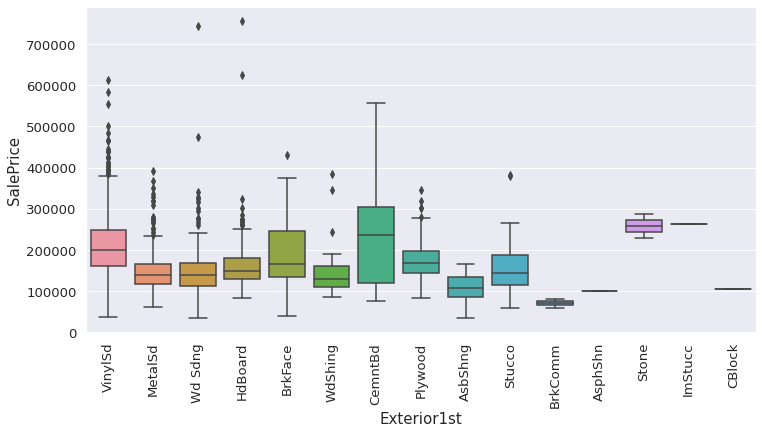

In [41]:
plt.figure(figsize=(12,6))
sns.boxplot(x= 'Exterior1st', y="SalePrice", data=df_train)
#plt.title('Exterior1st Vs SalePrice', fontsize = 20)
plt.xlabel('Exterior1st', fontsize = 15)
plt.ylabel('SalePrice', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

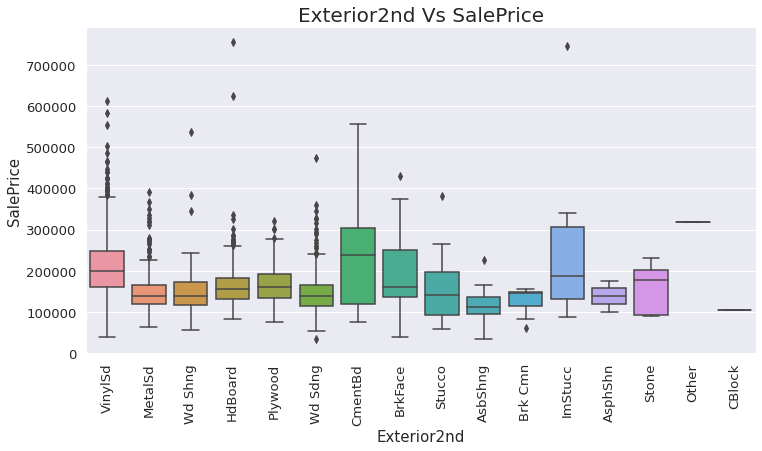

In [42]:
plt.figure(figsize=(12,6))
sns.boxplot(x= 'Exterior2nd', y="SalePrice", data=df_train)
plt.title('Exterior2nd Vs SalePrice', fontsize = 20)
plt.xlabel('Exterior2nd', fontsize = 15)
plt.ylabel('SalePrice', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

In [43]:
for col in list_obj_col:
    print(col, ':', df_train[col].nunique())
    print(df_train[col].value_counts())
    print('#'*50)

MSZoning : 5
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Street : 2
Pave    1454
Grvl       6
Name: Street, dtype: int64
##################################################
LotShape : 4
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
##################################################
LandContour : 4
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
Utilities : 2
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
LotConfig : 5
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
LandSlope : 3
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
################################################

# Handling outliers


Removing outliers is important step in data analysis. However, while removing outliers in ML we should be careful, because we do not know if there are not any outliers in test set.

##### SalePrice

In [44]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

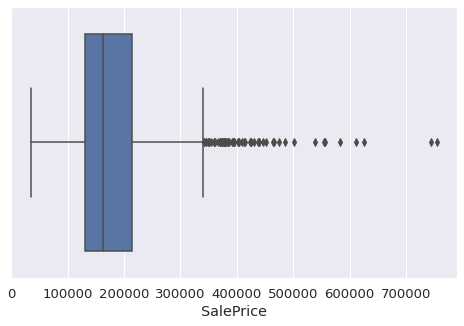

In [45]:
eda_plt(df_train['SalePrice'])

In [46]:
out_lier(df_train['SalePrice'],'SalePrice')

New boundary Is 466075.0


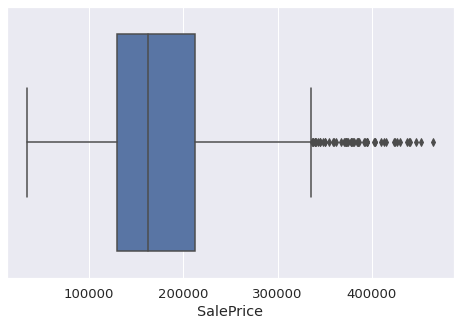

In [47]:
eda_plt(df_train['SalePrice'])

#### Normal distribution test SalePrice data


 mu = 177536.60 and sigma = 70375.16 and Mod = 140000.00



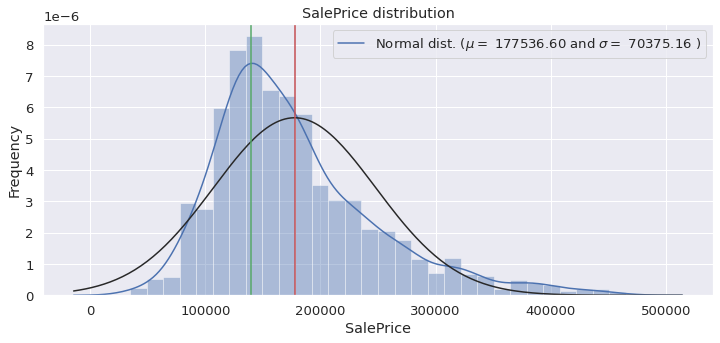

Skewness: 1.154566
Kurtosis: 1.515560


In [48]:
plt.figure(figsize=(12,5))
sns.distplot(df_train['SalePrice'] , fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(df_train['SalePrice'])
mod = statistics.mode(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f} and Mod = {:.2f}\n'.format(mu, sigma, mod))

#Now plot the distribution

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.axvline(x=mu, color='r', linestyle='-')
plt.axvline(x=mod, color='g', linestyle='-')

plt.show();
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

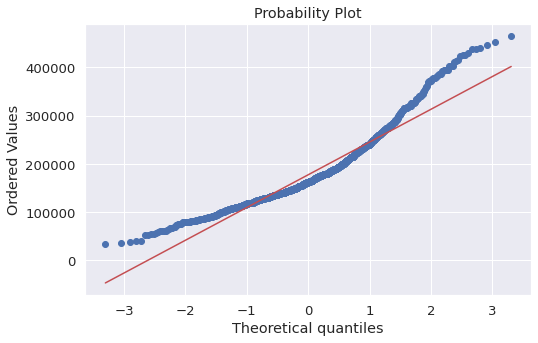

In [49]:
#Get also the QQ-plot
fig = plt.figure(figsize=(8, 5))
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show() 


 mu = 12.01 and sigma = 0.38 and Mod = 11.85



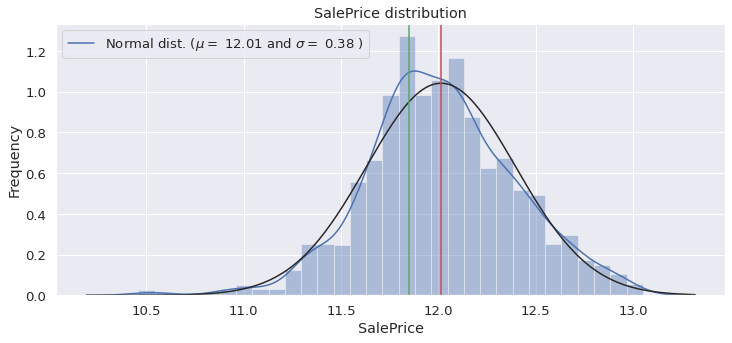

Skewness: -0.064523
Kurtosis: 0.534253


In [50]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
plt.figure(figsize=(12,5))
sns.distplot(df_train['SalePrice'] , fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(df_train['SalePrice'])
mod = statistics.mode(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f} and Mod = {:.2f}\n'.format(mu, sigma, mod))

#Now plot the distribution

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.axvline(x=mu, color='r', linestyle='-')
plt.axvline(x=mod, color='g', linestyle='-')

plt.show();
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

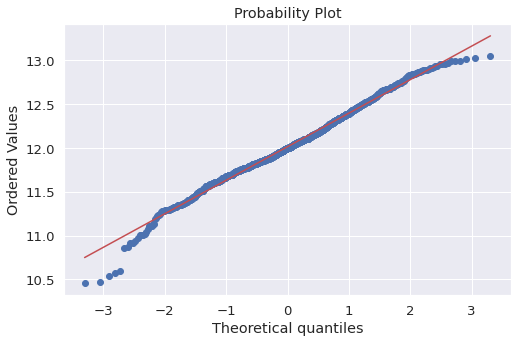

In [51]:
#Get also the QQ-plot
fig = plt.figure(figsize=(8, 5))
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show() 

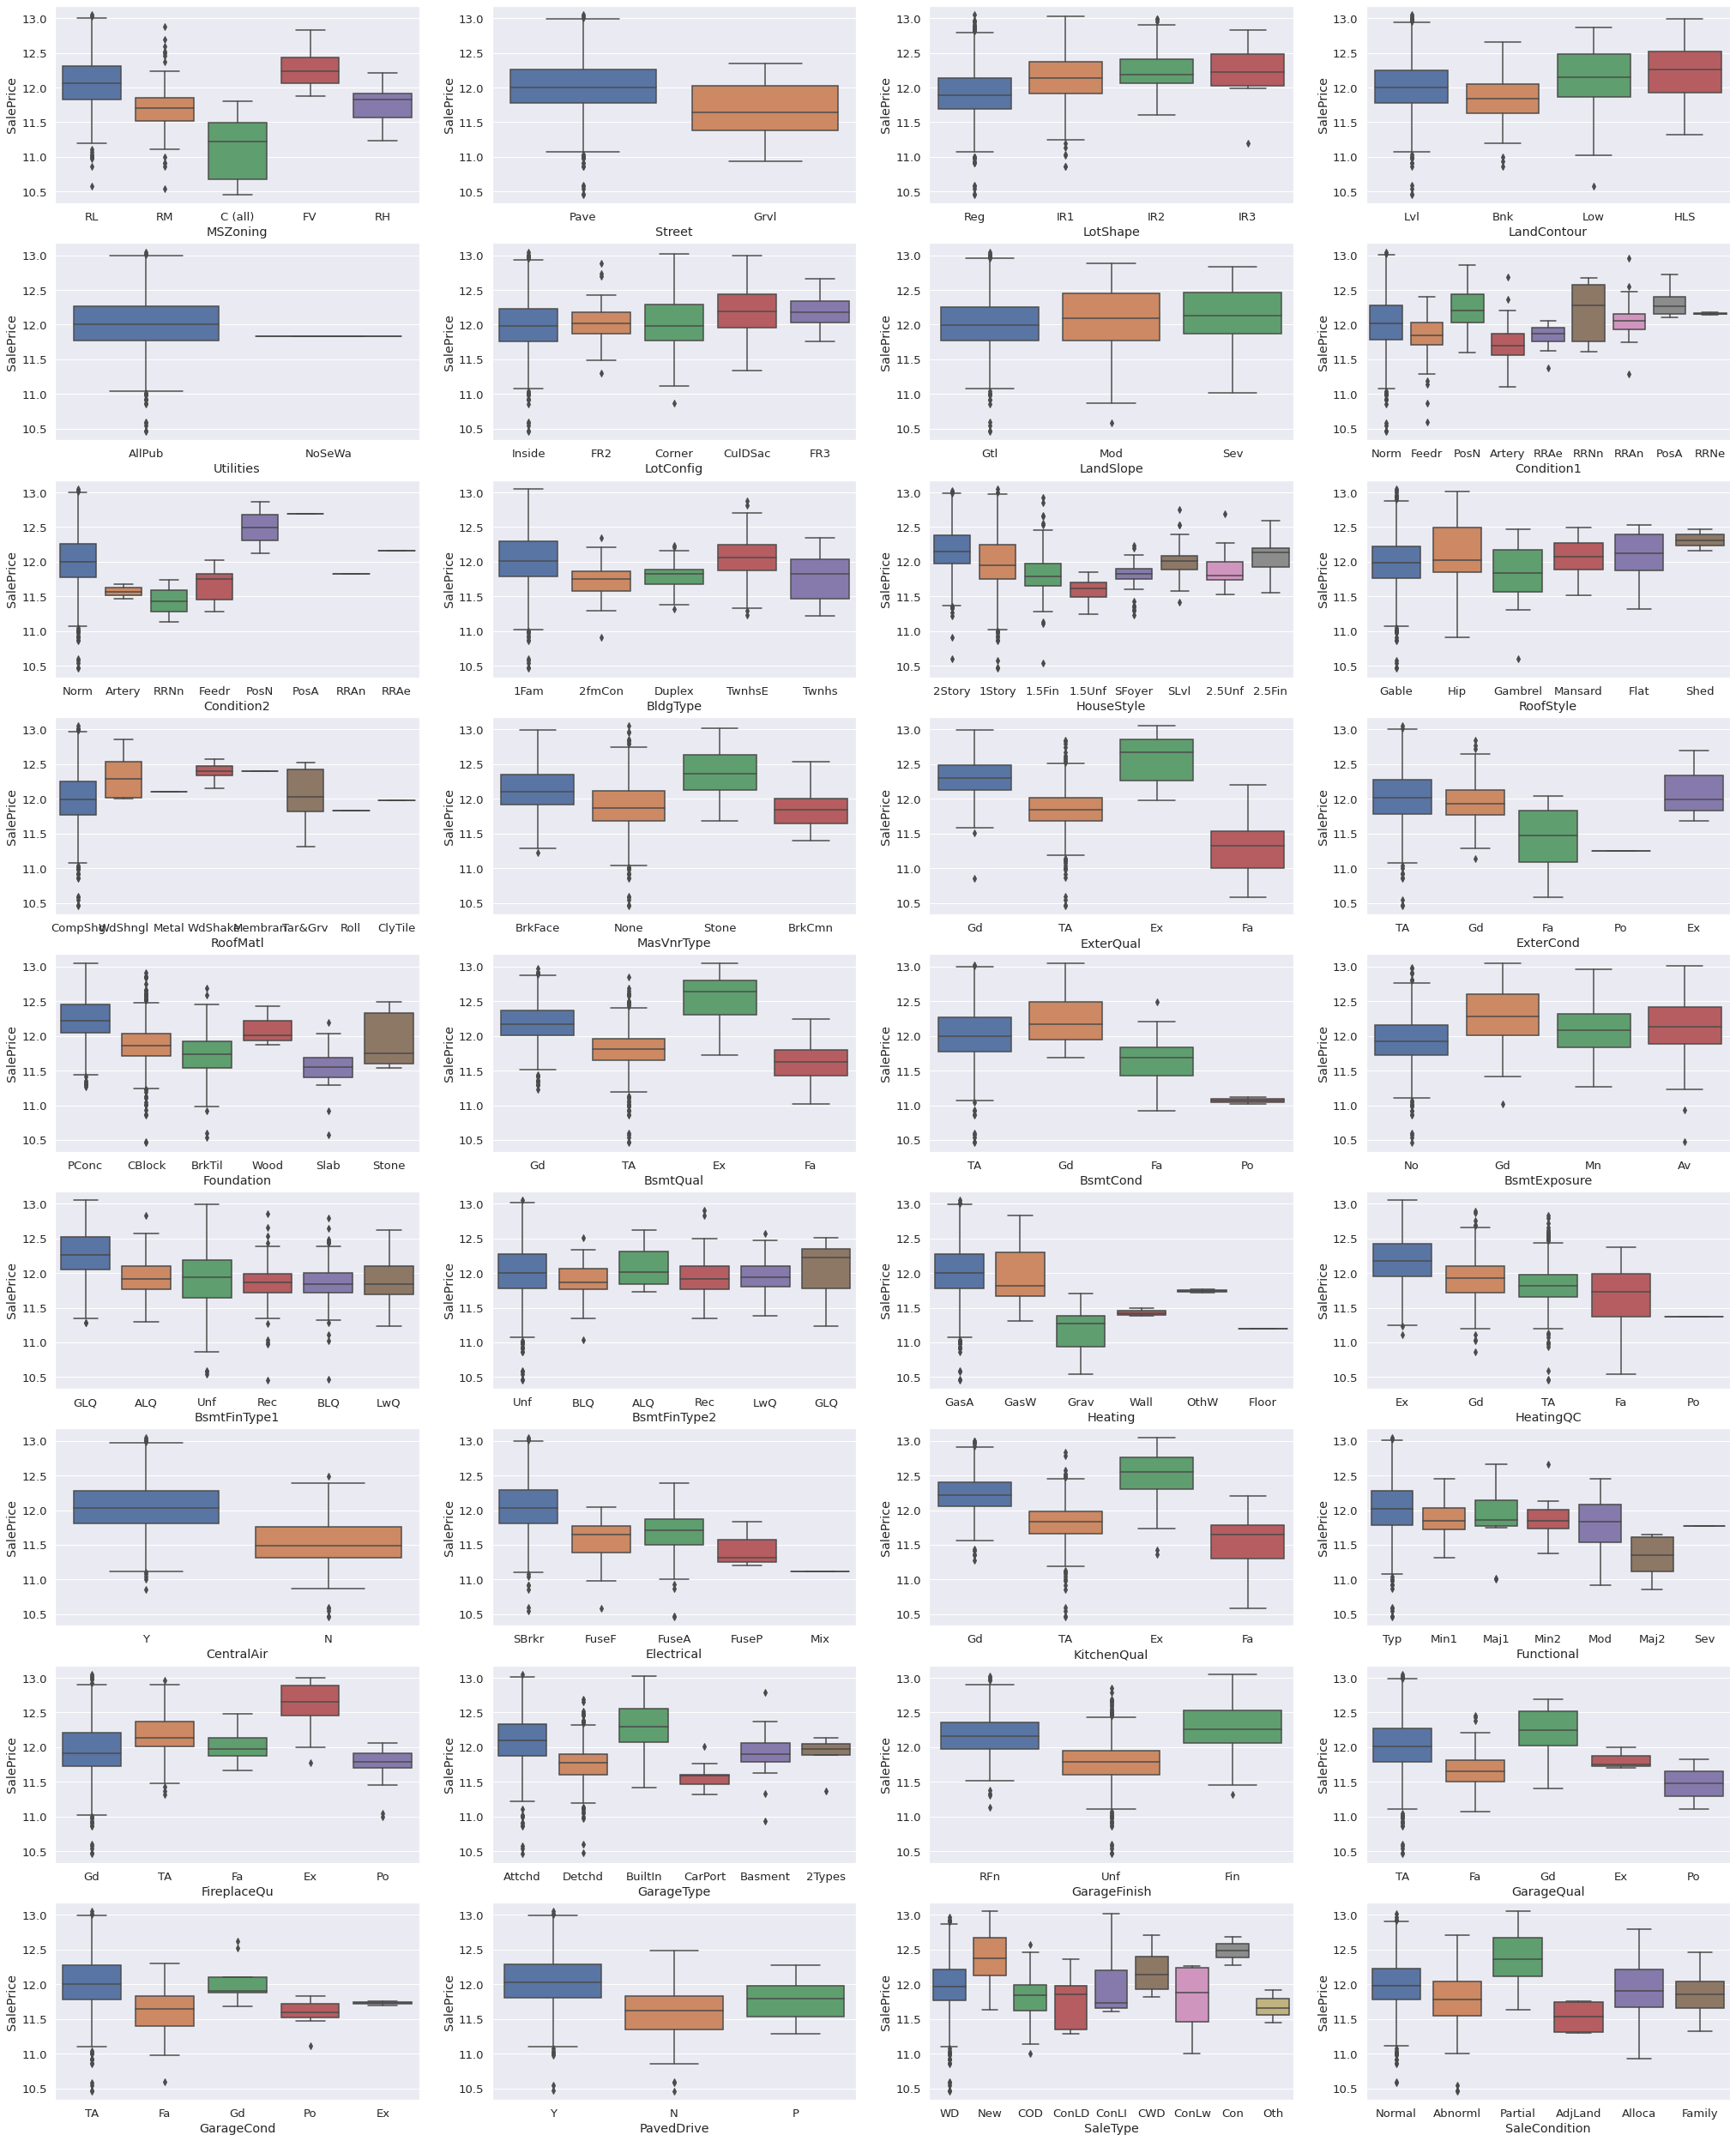

In [52]:
list_obj_col.remove('Neighborhood')
list_obj_col.remove('Exterior1st')
list_obj_col.remove('Exterior2nd')

cat_feats = list(list_obj_col)



X = df_train.copy()
y = X.pop("SalePrice")


plt.figure(figsize = (35,50))
i = 1
rows = len(cat_feats) // 4 + 1
for feature in cat_feats:
    ax = plt.subplot(rows,4,i)
    sns.boxplot(x=feature, y="SalePrice", data=df_train,ax=ax)
    i+=1

In [53]:
list_obj_col = list(df_train.select_dtypes(include='object').columns)

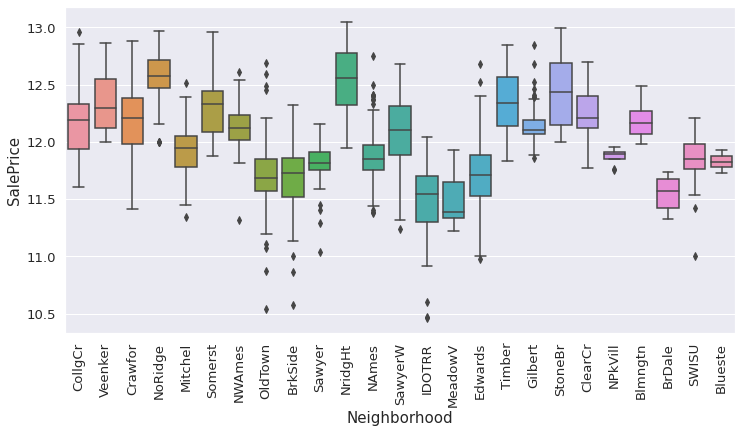

In [54]:
plt.figure(figsize=(12,6))
sns.boxplot(x= 'Neighborhood', y="SalePrice", data=df_train)
#plt.title('Neighborhood Vs SalePrice', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('SalePrice', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

skewness and kurtosis for SalePrice

In [55]:
list_obj_col = list(df_train.select_dtypes(include='object').columns)

In [56]:
list_num_col = list(df_train.select_dtypes(exclude ='object').columns)

In [57]:
# skewness and kurtosis for All Data
for col in list_num_col:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.41     Kurtosis: 021.91
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.14
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 016.40
FullBath        Skewness: 00.04     Kurtosis: 

Text(0.5, 1.0, 'LotArea vs SalePrice')

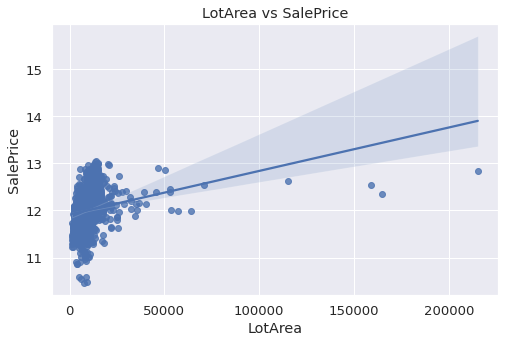

In [58]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.regplot(x='LotArea', y='SalePrice', data= df_train, scatter = True, fit_reg=True)
#plt.axhline(y=13.2, color='r')
#plt.axvline(x=24000, color='r')
plt.title("LotArea vs SalePrice")

### Multicollinearity Features

In [59]:
# features to consider removing
considered_features = list_num_col


# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

Variable       VIF
15      GrLivArea       inf
8      BsmtFinSF1       inf
9      BsmtFinSF2       inf
10      BsmtUnfSF       inf
11    TotalBsmtSF       inf
12       1stFlrSF       inf
13       2ndFlrSF       inf
14   LowQualFinSF       inf
25     GarageCars  5.662418
26     GarageArea  5.467892
5       YearBuilt  5.361292
36      SalePrice  5.301774
22   TotRmsAbvGrd  4.890254
3     OverallQual  3.718535
24    GarageYrBlt  3.317798
18       FullBath  2.964322
6    YearRemodAdd  2.456043
20   BedroomAbvGr  2.340971
16   BsmtFullBath  2.270606
19       HalfBath  2.174283
4     OverallCond  1.689474
0      MSSubClass  1.673488
23     Fireplaces  1.629532
21   KitchenAbvGr  1.595899
1     LotFrontage  1.568164
7      MasVnrArea  1.398985
29  EnclosedPorch  1.291441
2         LotArea  1.264998
27     WoodDeckSF  1.232047
28    OpenPorchSF  1.223065
17   BsmtHalfBath  1.153206
32       PoolArea  1.126616
31    ScreenPorch  1.116818
35         YrSold  1.055971
34         MoSold  1.051586
30      3SsnPorch  1.026431
33        MiscVal  1.023370

What is a good VIF value?
The higher the value, the greater the correlation of the variable with other variables. Values of more than 4 or 5 are sometimes regarded as being moderate to high, with values of 10 or more being regarded as very high.

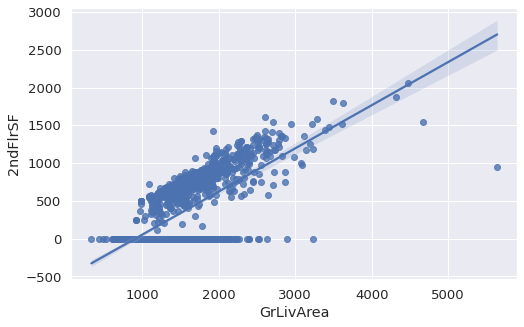

In [60]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.regplot(x='GrLivArea', y='2ndFlrSF', data= df_train, scatter = True, fit_reg=True) 
#plt.title("GrLivArea vs 2ndFlrSF")

Text(0.5, 1.0, 'GrLivArea vs 1stFlrSF')

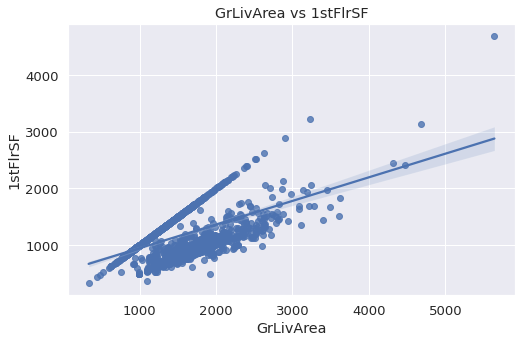

In [61]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.regplot(x='GrLivArea', y='1stFlrSF', data= df_train, scatter = True, fit_reg=True)
plt.title("GrLivArea vs 1stFlrSF") 

Text(0.5, 1.0, 'YearRemodAdd vs TotalBsmtSF')

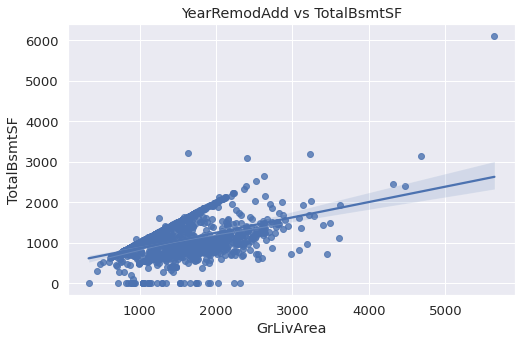

In [62]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.regplot(x='GrLivArea', y='TotalBsmtSF', data= df_train, scatter = True, fit_reg=True)  
plt.title("YearRemodAdd vs TotalBsmtSF") 

Text(0.5, 1.0, 'GrLivArea vs GarageArea')

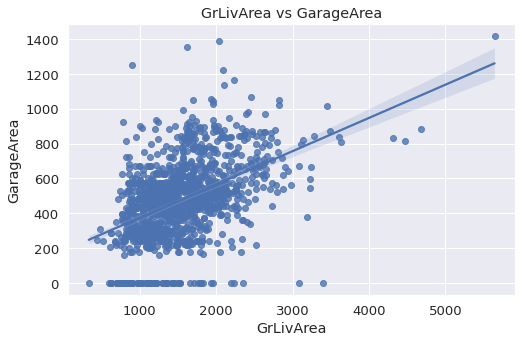

In [63]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.regplot(x='GrLivArea', y='GarageArea', data= df_train, scatter = True, fit_reg=True) 
plt.title("GrLivArea vs GarageArea") 

Text(0.5, 1.0, 'GrLivArea vs BsmtUnfSF')

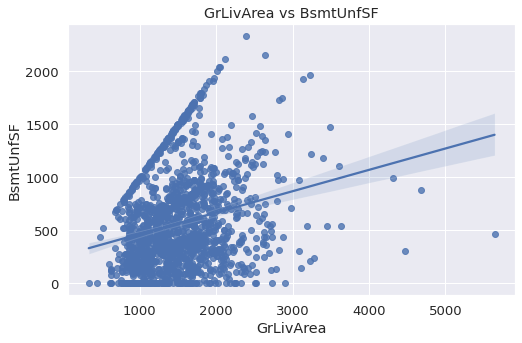

In [64]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.regplot(x='GrLivArea', y='BsmtUnfSF', data= df_train, scatter = True, fit_reg=True) 
plt.title("GrLivArea vs BsmtUnfSF") 

Text(0.5, 1.0, 'GrLivArea vs BsmtFinSF1')

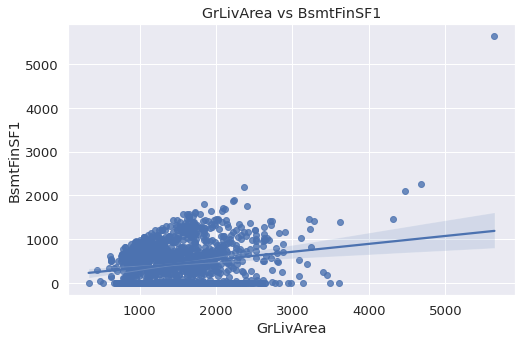

In [65]:

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.regplot(x='GrLivArea', y='BsmtFinSF1', data= df_train, scatter = True, fit_reg=True) 
plt.title("GrLivArea vs BsmtFinSF1") 

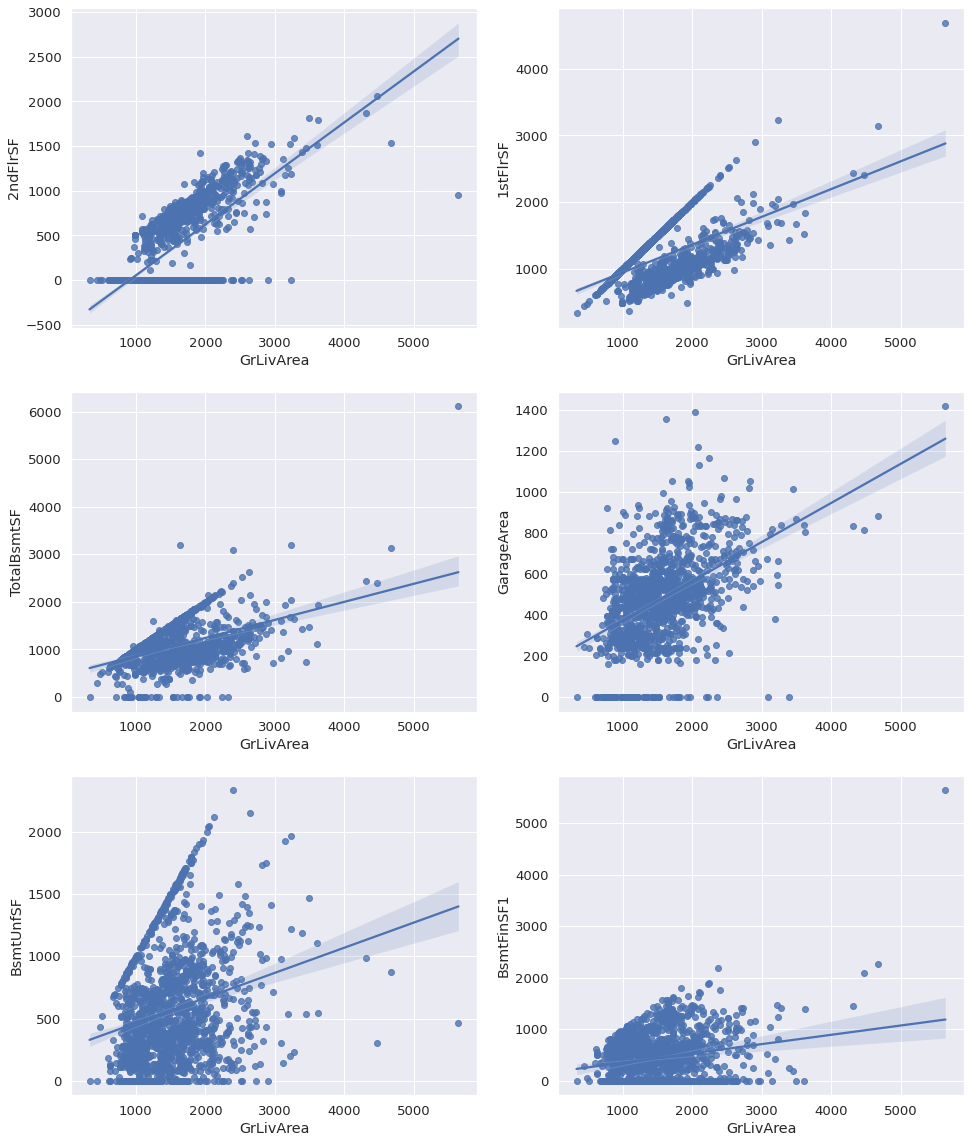

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(16, 20))

sns.regplot(ax=axes[0, 0], data=df_train, x='GrLivArea', y='2ndFlrSF')
sns.regplot(ax=axes[0, 1], data=df_train, x='GrLivArea', y='1stFlrSF')
sns.regplot(ax=axes[1, 0], data=df_train, x='GrLivArea', y='TotalBsmtSF')
sns.regplot(ax=axes[1, 1], data=df_train, x='GrLivArea', y='GarageArea')
sns.regplot(ax=axes[2, 0], data=df_train, x='GrLivArea', y='BsmtUnfSF')
sns.regplot(ax=axes[2, 1], data=df_train, x='GrLivArea', y='BsmtFinSF1')

In [67]:
df_train.drop(['GrLivArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], axis=1, inplace=True)

In [68]:
# update list_num_col
list_num_col = list(df_train.select_dtypes(exclude ='object').columns)
# features to consider removing
considered_features = list_num_col
# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

Variable       VIF
17     GarageCars  5.522757
18     GarageArea  5.259030
28      SalePrice  5.070385
5       YearBuilt  4.717801
14   TotRmsAbvGrd  3.627026
3     OverallQual  3.449481
16    GarageYrBlt  3.213340
10       FullBath  2.552400
6    YearRemodAdd  2.416232
12   BedroomAbvGr  2.265553
4     OverallCond  1.618864
15     Fireplaces  1.554247
1     LotFrontage  1.531482
13   KitchenAbvGr  1.481801
0      MSSubClass  1.466854
11       HalfBath  1.438638
8    BsmtFullBath  1.325838
7      MasVnrArea  1.317570
21  EnclosedPorch  1.280834
2         LotArea  1.247534
19     WoodDeckSF  1.218239
20    OpenPorchSF  1.200472
23    ScreenPorch  1.106299
24       PoolArea  1.087431
9    BsmtHalfBath  1.078349
27         YrSold  1.054095
26         MoSold  1.048030
22      3SsnPorch  1.023307
25        MiscVal  1.020459

In [69]:
df_train.shape

(1460, 68)

OverallQual  YearBuilt  YearRemodAdd  FullBath  TotRmsAbvGrd  \
OverallQual      1.000000   0.572323      0.550684  0.550600      0.427452   
YearBuilt        0.572323   1.000000      0.592855  0.468271      0.095589   
YearRemodAdd     0.550684   0.592855      1.000000  0.439046      0.191740   
FullBath         0.550600   0.468271      0.439046  1.000000      0.554784   
TotRmsAbvGrd     0.427452   0.095589      0.191740  0.554784      1.000000   
Fireplaces       0.396765   0.147716      0.112581  0.243671      0.326114   
GarageYrBlt      0.514231   0.777182      0.616444  0.466809      0.139519   
GarageCars       0.600671   0.537850      0.420622  0.469672      0.362289   
GarageArea       0.562022   0.478954      0.371600  0.405656      0.337822   
SalePrice        0.786999   0.590389      0.566282  0.568895      0.491339   

              Fireplaces  GarageYrBlt  GarageCars  GarageArea  SalePrice  
OverallQual     0.396765     0.514231    0.600671    0.562022   0.786999  
YearBuilt       0.147716     0.777182    0.537850    0.478954   0.590389  
YearRemodAdd    0.112581     0.616444    0.420622    0.371600   0.566282  
FullBath        0.243671     0.466809    0.469672    0.405656   0.568895  
TotRmsAbvGrd    0.326114     0.139519    0.362289    0.337822   0.491339  
Fireplaces      1.000000     0.042967    0.300789    0.269141   0.469566  
GarageYrBlt     0.042967     1.000000    0.474313    0.468804   0.490238  
GarageCars      0.300789     0.474313    1.000000    0.882475   0.665138  
GarageArea      0.269141     0.468804    0.882475    1.000000   0.631894  
SalePrice       0.469566     0.490238    0.665138    0.631894   1.000000

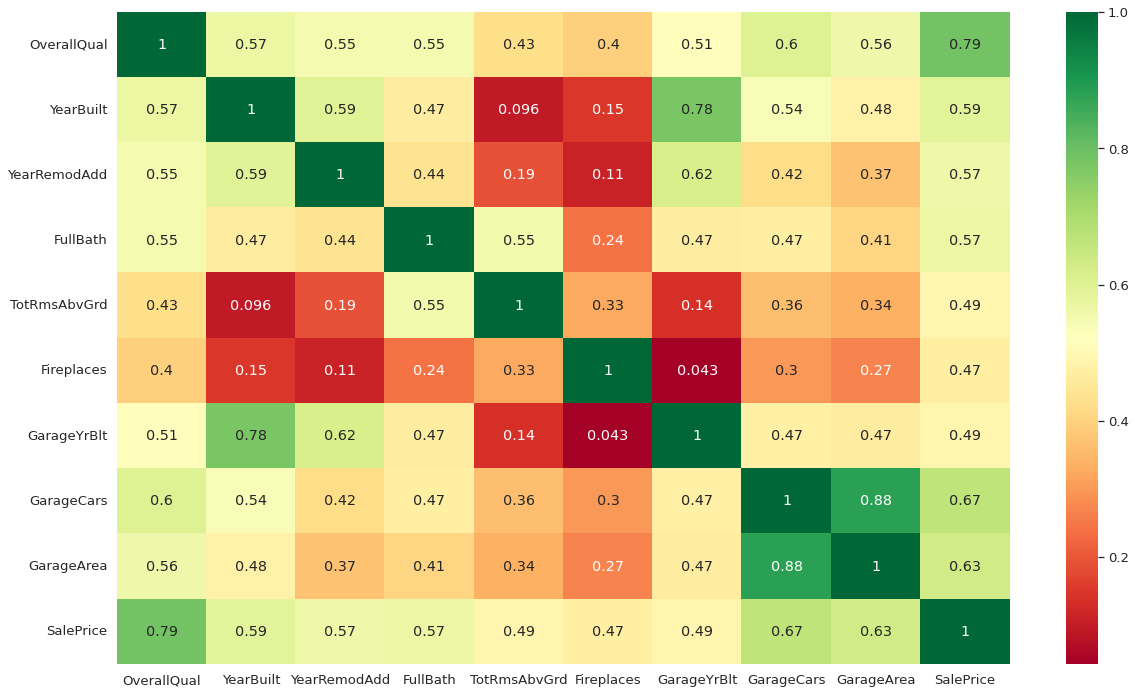

In [70]:
corrmat = df_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.4]
plt.figure(figsize=(20,12))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
df_train[top_corr_features].corr()

# Preprocessing Testing Data

<a id='wrangling'></a>
## Data Wrangling

> Each data project requires a unique approach to ensuring that its final data set is reliable, accessible, and easier to analyze.

### General Properties

In [71]:
df_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [72]:
df_test.shape

(1459, 80)

In [73]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

> #### Observations from above dataset are:
> <ol>
> Looking at the displayed information that represents the training data for predicting house prices, we notice that there are many data missing for some variables, which require processing or deletion.</li>



### Numerical and Categorical features

In [74]:
list_num_col = list(df_test.select_dtypes(exclude ='object').columns)
print("Number of Numerical features: ", len(list_num_col))

list_obj_col = list(df_test.select_dtypes(include='object').columns)
print("Number of Categorical features: ", len(list_obj_col))

Number of Numerical features:  37
Number of Categorical features:  43


In [75]:
print(df_test[list_num_col].columns)
print("*"*100)
print(df_test[list_obj_col].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')
****************************************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'Bs

## Data Cleaning
 
> #### Information That We Need To Delete Or Modify
1. Exploring the missing values
2. Handling missing values
3. Check duplicate rows from the dataset
4. Remove the unused colums that are not needes in the analysis process.

#### 1- Exploring the missing values
>- Using a heatmap to quickly identify missing data in each variable, missing data is checked and identified on variables that need to be processed or deleted.

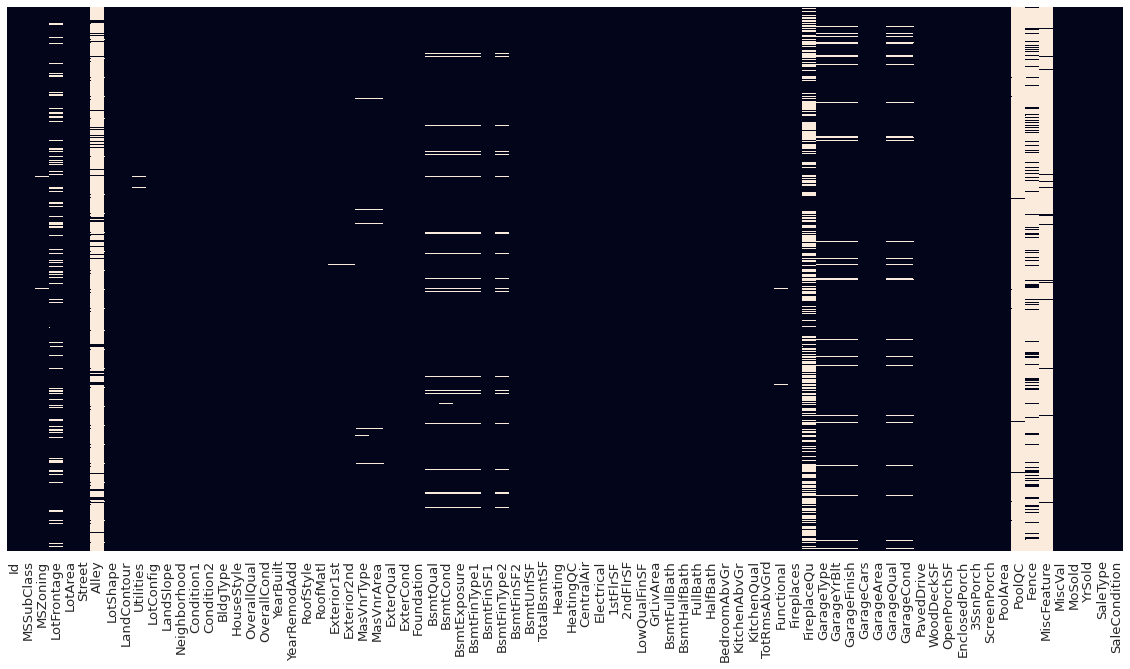

In [76]:
plt.subplots(figsize=(20, 10))
sns.heatmap(df_test.isnull(),yticklabels=False,cbar=False);

>- The number of missing data in each variable in the training data

In [77]:
sum(df_test.isna().any())

33

>- We can quantify the missing data in each variable in a more explicit manner using a bar chart.

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

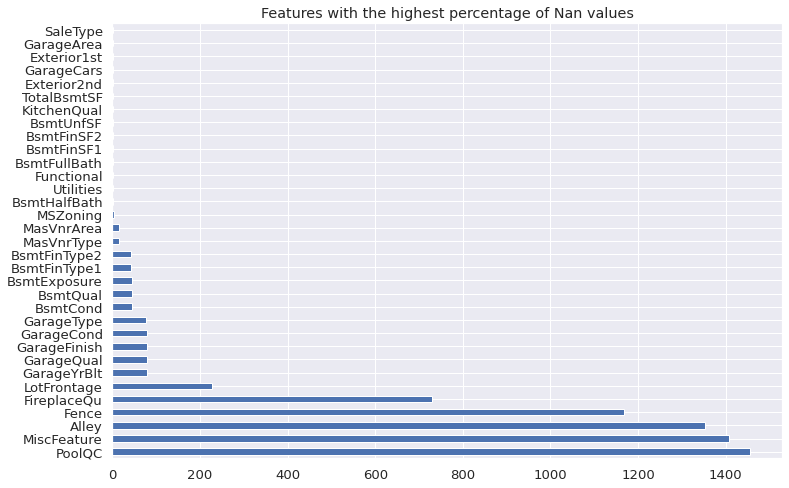

In [78]:
test_col_nan = df_test.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
test_col_nan[test_col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

>- It is also possible to indicate the percentages of missing data for each variable.

In [79]:
# See if there are missing values in any of the columns
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageFinish     78  0.053461
GarageCond       78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtQual         44  0.030158
BsmtExposure     44  0.030158
BsmtFinType1     42  0.028787
BsmtFinType2     42  0.028787
MasVnrType       16  0.010966
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtHalfBath      2  0.001371

> Observations from above dataset are:
> <ol>
> Each variable (PoolQC, MiscFeature, Alley, Fence) contains approx more than 80% missing data, which means that keeping them will not benefit the analysis with anything. On the contrary, if they are processed and kept, they may lead to misleading results, so we will, in the next step, delete them.</li>

#### 2-  Handling missing values
>  - Drop variables that contain missing values over 80%
>
> - Filling Missing Values with (Mean - Mod).

>- Drop variables that contain missing values over 80%.

In [80]:
df_test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

>-  The number of missing data in each variable in the training data After deleting the columns of the variables (PoolQC, MiscFeature, Alley, Fence), Because they contain more than 80% missing data.

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

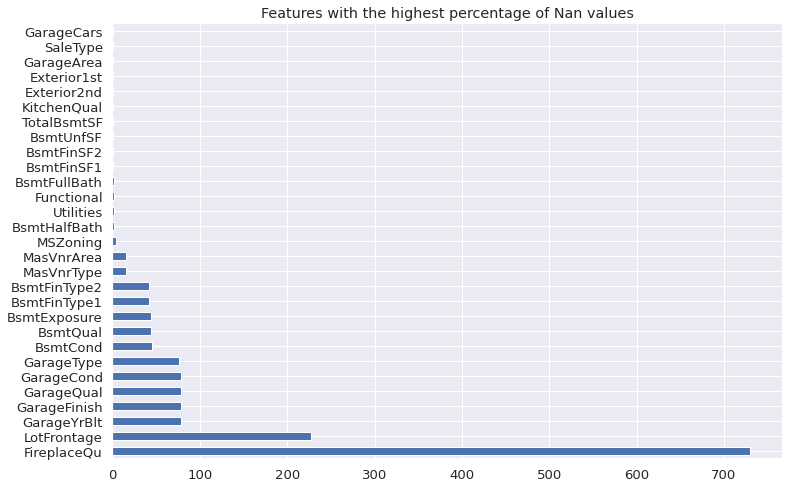

In [81]:
test_col_nan = df_test.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
test_col_nan[test_col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

>- The number of missing data in each variable in the training data

In [82]:
sum(df_test.isna().any())

29

> - Filling Missing Values with (Mean - Mod) according to the variable type
 

In [83]:
list_obj_col = list(df_test.select_dtypes(include='object').columns)

In [84]:
list_num_col = list(df_test.select_dtypes(exclude ='object').columns)

In [85]:
fillna_all(df_test)

In [86]:
df_test.shape

(1459, 76)

In [87]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [88]:
# data description
df_test.describe().round(2)

Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
count  1459.00     1459.00      1459.00   1459.00      1459.00      1459.00   
mean   2190.00       57.38        68.33   9819.16         6.08         5.55   
std     421.32       42.75        20.57   4955.52         1.44         1.11   
min    1461.00       20.00        21.00   1470.00         1.00         1.00   
25%    1825.50       20.00        60.00   7391.00         5.00         5.00   
50%    2190.00       50.00        67.00   9399.00         6.00         5.00   
75%    2554.50       70.00        78.00  11517.50         7.00         6.00   
max    2919.00      190.00       200.00  56600.00        10.00         9.00   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageArea  \
count    1459.00       1459.00     1459.00     1459.00  ...     1459.00   
mean     1971.36       1983.66       99.67      439.14  ...      472.77   
std        30.39         21.13      177.00      455.12  ...      216.97   
min      1879.00       1950.00        0.00        0.00  ...        0.00   
25%      1953.00       1963.00        0.00        0.00  ...      318.00   
50%      1973.00       1992.00        0.00      350.50  ...      480.00   
75%      2001.00       2004.00      162.00      752.00  ...      576.00   
max      2010.00       2010.00     1290.00     4010.00  ...     1488.00   

       WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count     1459.00      1459.00        1459.00    1459.00      1459.00   
mean        93.17        48.31          24.24       1.79        17.06   
std        127.74        68.88          67.23      20.21        56.61   
min          0.00         0.00           0.00       0.00         0.00   
25%          0.00         0.00           0.00       0.00         0.00   
50%          0.00        28.00           0.00       0.00         0.00   
75%        168.00        72.00           0.00       0.00         0.00   
max       1424.00       742.00        1012.00     360.00       576.00   

       PoolArea   MiscVal   MoSold   YrSold  
count   1459.00   1459.00  1459.00  1459.00  
mean       1.74     58.17     6.10  2007.77  
std       30.49    630.81     2.72     1.30  
min        0.00      0.00     1.00  2006.00  
25%        0.00      0.00     4.00  2007.00  
50%        0.00      0.00     6.00  2008.00  
75%        0.00      0.00     8.00  2009.00  
max      800.00  17000.00    12.00  2010.00  

[8 rows x 37 columns]

#### 3. Check duplicate rows from the dataset

In [89]:
print(df_test.duplicated(keep=False).sum())

0


#### 4. Remove the unused colums that are not needes in the analysis process.

In [90]:
df_test.drop(['GrLivArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], axis=1, inplace=True)

In [91]:
df_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0  1461          20       RH         80.0    11622   Pave      Reg   
1  1462          20       RL         81.0    14267   Pave      IR1   
2  1463          60       RL         74.0    13830   Pave      IR1   
3  1464          60       RL         78.0     9978   Pave      IR1   
4  1465         120       RL         43.0     5005   Pave      IR1   

  LandContour Utilities LotConfig  ... OpenPorchSF EnclosedPorch 3SsnPorch  \
0         Lvl    AllPub    Inside  ...           0             0         0   
1         Lvl    AllPub    Corner  ...          36             0         0   
2         Lvl    AllPub    Inside  ...          34             0         0   
3         Lvl    AllPub    Inside  ...          36             0         0   
4         HLS    AllPub    Inside  ...          82             0         0   

  ScreenPorch PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         120        0       0       6    2010        WD         Normal  
1           0        0   12500       6    2010        WD         Normal  
2           0        0       0       3    2010        WD         Normal  
3           0        0       0       6    2010        WD         Normal  
4         144        0       0       1    2010        WD         Normal  

[5 rows x 68 columns]

In [92]:
df_test.shape

(1459, 68)

In [93]:
df_train.shape, df_test.shape

((1460, 68), (1459, 68))

# Concatenate Data

In [94]:
df_train_test = pd.concat([df_train.drop('SalePrice', axis= 1),df_test],axis=0)

In [95]:
df_train_test.shape

(2919, 68)

# Dummy Variable

In [96]:
dummy= pd.get_dummies(df_train_test[list_obj_col],prefix=list_obj_col)

In [97]:
dummy.shape

(2919, 239)

In [98]:
df_train_test.drop(list_obj_col,axis=1, inplace=True)

In [99]:
df_train_test.shape

(2919, 29)

In [100]:
df_train_test_final = pd.concat([df_train_test,dummy],axis=1)

**Removing Id column**

In [101]:
# Dropping columns for both train and test dataset
df_train_test_final = df_train_test_final.drop("Id", axis=1)

In [102]:
df_train_test_final.shape

(2919, 267)

In [103]:
df_train_test_final.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFullBath  BsmtHalfBath  ...  SaleType_ConLw  \
0          2003       196.0           1.0           0.0  ...               0   
1          1976         0.0           0.0           1.0  ...               0   
2          2002       162.0           1.0           0.0  ...               0   
3          1970         0.0           1.0           0.0  ...               0   
4          2000       350.0           1.0           0.0  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      1   
4             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 267 columns]

# Split Data (Train / Tast)

In [104]:
X = df_train_test_final.iloc[0:1460]
y = df_train['SalePrice']

In [105]:
test =df_train_test_final.iloc[1460:]

In [106]:
X.shape

(1460, 267)

In [107]:
test.shape

(1459, 267)

In [108]:
y.shape

(1460,)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=SEED)

In [110]:
y_train.shape

(1095,)

# Machine Learning 
# Regression Models and Comparison of Results

## Linear Regression

In [111]:
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
regressor = GridSearchCV(linreg, parameters, cv=5, verbose=1 )
regressor.fit(X_train, y_train)
pred_regressor = regressor.predict(test)
# back to normal value using built-in numpy exp() function
pred_regressor_log = np.exp(pred_regressor)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [112]:
df_sub_linreg = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_regressor_log})

In [113]:
df_sub_linreg.head(20)

Id      SalePrice
0   1461  127660.600520
1   1462  142687.325240
2   1463  174291.762792
3   1464  198106.667851
4   1465  176428.751170
5   1466  169157.420726
6   1467  175245.216887
7   1468  161858.526093
8   1469  165117.894164
9   1470  127815.325812
10  1471  171988.386090
11  1472  100895.145705
12  1473   94763.344977
13  1474  137135.245832
14  1475  108609.372339
15  1476  289049.612847
16  1477  255168.594145
17  1478  291268.478119
18  1479  322698.799718
19  1480  333118.686360

### Model Evaluation 

Mean absolute error for Linear Regression: 0.0859
Mean squared error for Linear Regression: 0.0153
Root mean squared error for Linear Regression: 0.1237


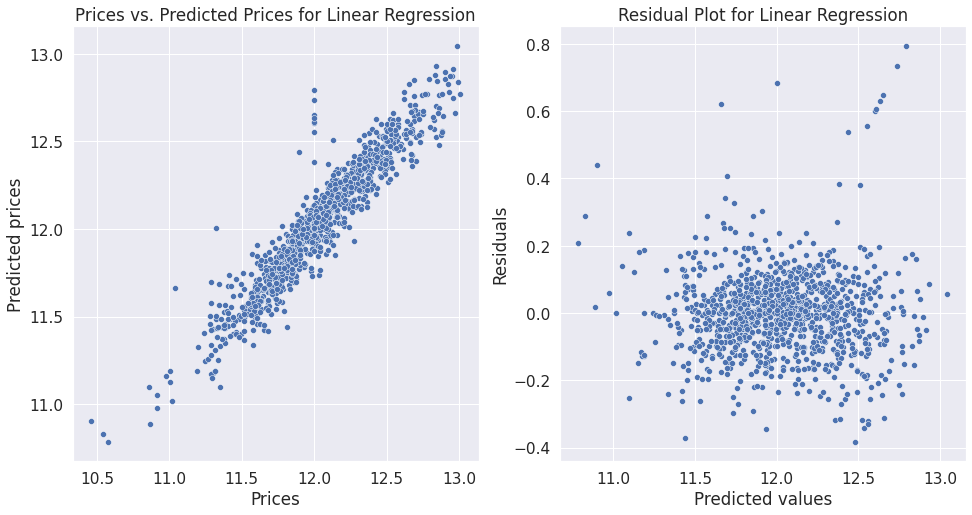

R² for Linear Regression : 0.8929758463394943


In [114]:
y_pred = regressor.predict(X_train)

mae_reg = mean_absolute_error(y_train, y_pred)
mse_reg = mean_squared_error(y_train, y_pred)
rmse_reg = np.sqrt(mse_reg)

print(f'Mean absolute error for Linear Regression: {mae_reg:.4f}')
print(f'Mean squared error for Linear Regression: {mse_reg:.4f}')
print(f'Root mean squared error for Linear Regression: {rmse_reg:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for Linear Regression");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_reg = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for Linear Regression :', r2_reg)

## Ridge Regression

In [115]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=5, verbose=1)
grid_ridge.fit(X_train, y_train)
pred_ridge = grid_ridge.predict(test)
# back to normal value using built-in numpy exp() function
pred_ridge_log = np.exp(pred_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [116]:
df_sub_ridge = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_ridge_log})

In [117]:
df_sub_ridge.head(20)

Id      SalePrice
0   1461  123920.218709
1   1462  141001.190398
2   1463  176974.673740
3   1464  197096.609428
4   1465  180971.571971
5   1466  171123.349075
6   1467  169365.904163
7   1468  164895.424890
8   1469  163664.631812
9   1470  134075.208632
10  1471  178130.524222
11  1472  103382.981707
12  1473  101480.089018
13  1474  141541.736353
14  1475  112273.849541
15  1476  292247.918117
16  1477  243599.461659
17  1478  279781.857415
18  1479  290713.474729
19  1480  344473.343737

### Model Evaluation 

Mean absolute error for Ridge Regression: 0.0942
Mean squared error for Ridge Regression: 0.0185
Root mean squared error for Ridge Regression: 0.1362


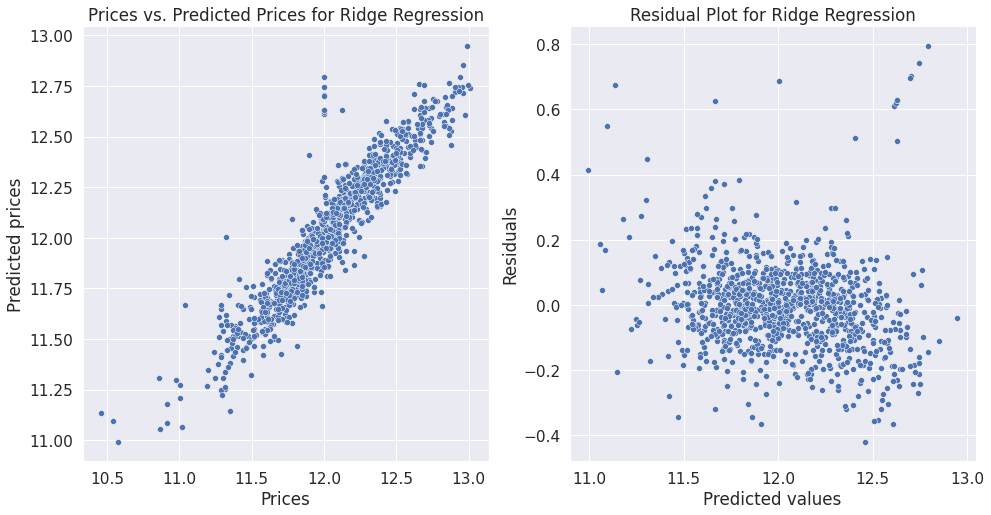

R² for Ridge Regression : 0.8703133467372208


In [118]:
y_pred = grid_ridge.predict(X_train)

mae_ridge = mean_absolute_error(y_train, y_pred)
mse_ridge = mean_squared_error(y_train, y_pred)
rmse_ridge = np.sqrt(mse_ridge)

print(f'Mean absolute error for Ridge Regression: {mae_ridge:.4f}')
print(f'Mean squared error for Ridge Regression: {mse_ridge:.4f}')
print(f'Root mean squared error for Ridge Regression: {rmse_ridge:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for Ridge Regression");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_ridge = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for Ridge Regression :', r2_ridge)

## Lasso Regression

In [119]:
lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=5, verbose=1)
grid_lasso.fit(X_train, y_train)

pred_lasso = grid_lasso.predict(test)
# back to normal value using built-in numpy exp() function
pred_lasso_log = np.exp(pred_lasso)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [120]:
df_sub_lasso = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_lasso_log})

In [121]:
df_sub_lasso.head(20)

Id      SalePrice
0   1461  119754.439094
1   1462  121022.466618
2   1463  171380.568911
3   1464  200430.298221
4   1465  179074.611272
5   1466  170976.297738
6   1467  190504.423480
7   1468  166387.893849
8   1469  182055.162194
9   1470  124154.997647
10  1471  200562.239068
11  1472  104941.951574
12  1473   94998.435239
13  1474  151900.852172
14  1475  120863.455582
15  1476  292757.575980
16  1477  242484.117306
17  1478  274890.094437
18  1479  285879.061701
19  1480  334426.737868

### Model Evaluation 

Mean absolute error for Lasso Regression: 0.0997
Mean squared error for Lasso Regression: 0.0207
Root mean squared error for Lasso Regression: 0.1439


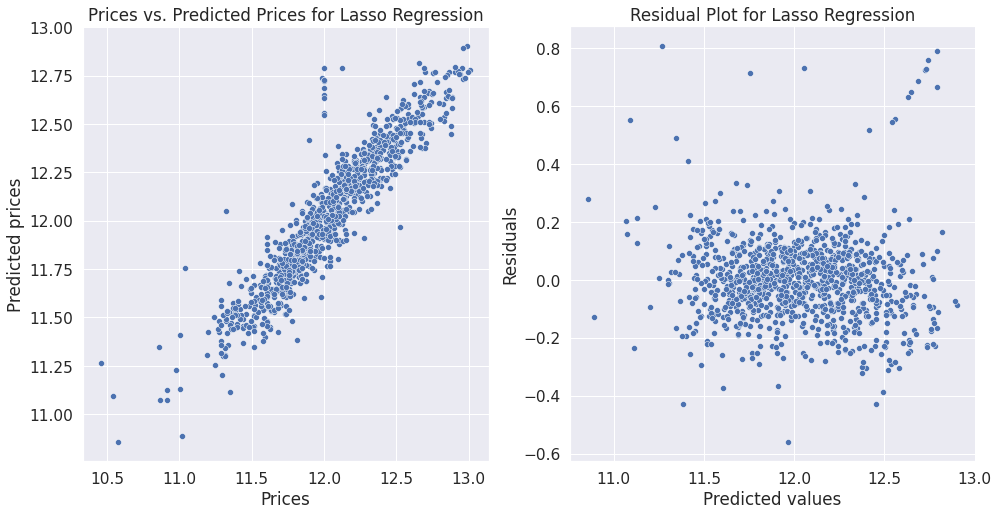

R² for Lasso Regression : 0.8552383744560393


In [122]:
y_pred = grid_lasso.predict(X_train)

mae_lasso = mean_absolute_error(y_train, y_pred)
mse_lasso = mean_squared_error(y_train, y_pred)
rmse_lasso = np.sqrt(mse_lasso)

print(f'Mean absolute error for Lasso Regression: {mae_lasso:.4f}')
print(f'Mean squared error for Lasso Regression: {mse_lasso:.4f}')
print(f'Root mean squared error for Lasso Regression: {rmse_lasso:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for Lasso Regression");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for Lasso Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_lasso = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for Lasso Regression :', r2_lasso)

## Elastic net Logistic Regression

In [123]:
enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=5, verbose=1)
grid_enet.fit(X_train, y_train)

pred_enet = grid_enet.predict(test)
# back to normal value using built-in numpy exp() function
pred_enet_log = np.exp(pred_enet)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [124]:
df_sub_ened = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_enet_log})

In [125]:
df_sub_ened.head(20)

Id      SalePrice
0   1461  137599.028744
1   1462  118589.338258
2   1463  170558.422284
3   1464  203744.283814
4   1465  184139.088852
5   1466  175534.233015
6   1467  196749.316945
7   1468  169756.418106
8   1469  187980.448590
9   1470  122067.736041
10  1471  195491.887758
11  1472  113884.560462
12  1473  102627.106442
13  1474  152743.354841
14  1475  128428.637411
15  1476  298789.652649
16  1477  241767.471111
17  1478  274265.551239
18  1479  257907.962929
19  1480  351611.385276

### Model Evaluation 

Mean absolute error for Elastic Net : 0.1135
Mean squared error for Elastic Net : 0.0273
Root mean squared error for Elastic Net : 0.1651


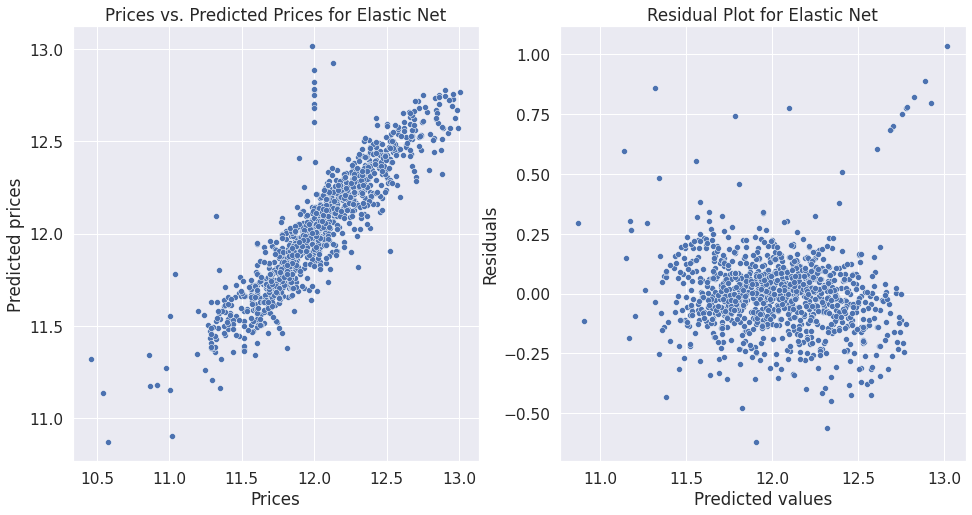

R² for Elastic Net : 0.8092600989426444


In [126]:
y_pred = grid_enet.predict(X_train)

mae_elastic_net = mean_absolute_error(y_train, y_pred)
mse_elastic_net = mean_squared_error(y_train, y_pred)
rmse_elastic_net = np.sqrt(mse_elastic_net)

print(f'Mean absolute error for Elastic Net : {mae_elastic_net:.4f}')
print(f'Mean squared error for Elastic Net : {mse_elastic_net:.4f}')
print(f'Root mean squared error for Elastic Net : {rmse_elastic_net:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for Elastic Net");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for Elastic Net")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_elastic_net = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for Elastic Net :', r2_elastic_net)

##Stochastic Gradient Descent (SGD Regressor) 

> Linear model fitted by minimizing a regularized empirical loss with SGD. SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). 

In [127]:
sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv=5, verbose=1)
grid_sgd.fit(X_train, y_train)

pred_sgd = grid_sgd.predict(test)
# back to normal value using built-in numpy exp() function
pred_sgd_log = np.exp(pred_sgd)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [128]:
df_sub_sgd = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_sgd_log})

In [129]:
df_sub_sgd.head(20)

Id  SalePrice
0   1461        0.0
1   1462        0.0
2   1463        0.0
3   1464        0.0
4   1465        0.0
5   1466        0.0
6   1467        0.0
7   1468        0.0
8   1469        0.0
9   1470        0.0
10  1471        0.0
11  1472        inf
12  1473        inf
13  1474        0.0
14  1475        inf
15  1476        0.0
16  1477        0.0
17  1478        0.0
18  1479        0.0
19  1480        0.0

### Model Evaluation 

Mean absolute error for SGDRegressor : 10640778878523752.0000
Mean squared error for SGDRegressor : 277796388062509007286324498006016.0000
Root mean squared error for SGDRegressor : 16667224965857664.0000


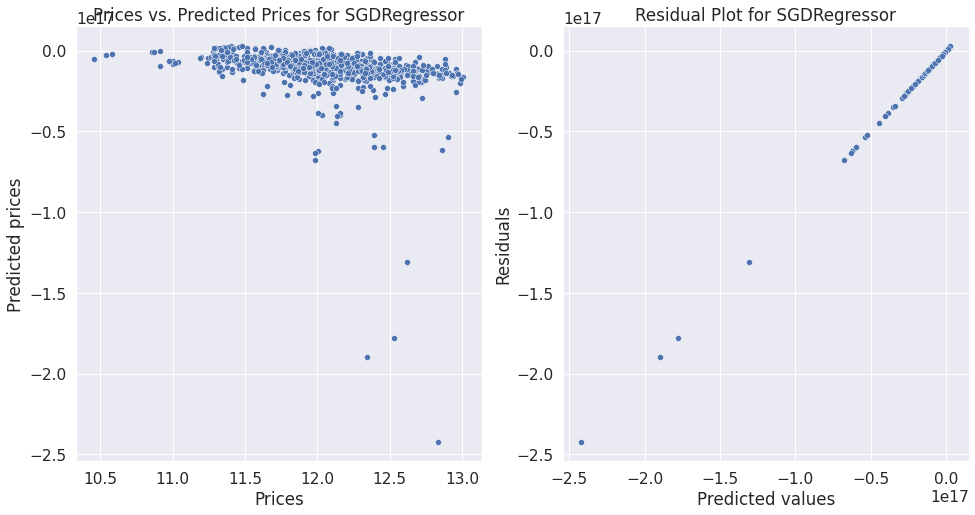

R² for SGDRegressor : -1.9430848074225026e+33


In [130]:
y_pred = grid_sgd.predict(X_train)

mae_sgd = mean_absolute_error(y_train, y_pred)
mse_sgd = mean_squared_error(y_train, y_pred)
rmse_sgd = np.sqrt(mse_sgd)

print(f'Mean absolute error for SGDRegressor : {mae_sgd:.4f}')
print(f'Mean squared error for SGDRegressor : {mse_sgd:.4f}')
print(f'Root mean squared error for SGDRegressor : {rmse_sgd:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for SGDRegressor");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for SGDRegressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_sgd = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for SGDRegressor :', r2_sgd)

## Decision Tree Regressor

In [131]:
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)
pred_dtr = dtreg.predict(test)
# back to normal value using built-in numpy exp() function
pred_dtr_log = np.exp(pred_dtr)

In [132]:
df_sub_dtr = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_dtr_log})

In [133]:
df_sub_dtr.head(20)

Id  SalePrice
0   1461   114500.0
1   1462   124500.0
2   1463   175000.0
3   1464   179000.0
4   1465   212000.0
5   1466   187500.0
6   1467   186500.0
7   1468   176432.0
8   1469   180000.0
9   1470   153500.0
10  1471   235000.0
11  1472    88000.0
12  1473   112000.0
13  1474   148500.0
14  1475   180000.0
15  1476   325000.0
16  1477   275000.0
17  1478   314813.0
18  1479   275000.0
19  1480   354000.0

### Model Evaluation 

Mean absolute error for Decision Tree Regressor : 0.0000
Mean squared error for Decision Tree Regressor : 0.0000
Root mean squared error for Decision Tree Regressor : 0.0000


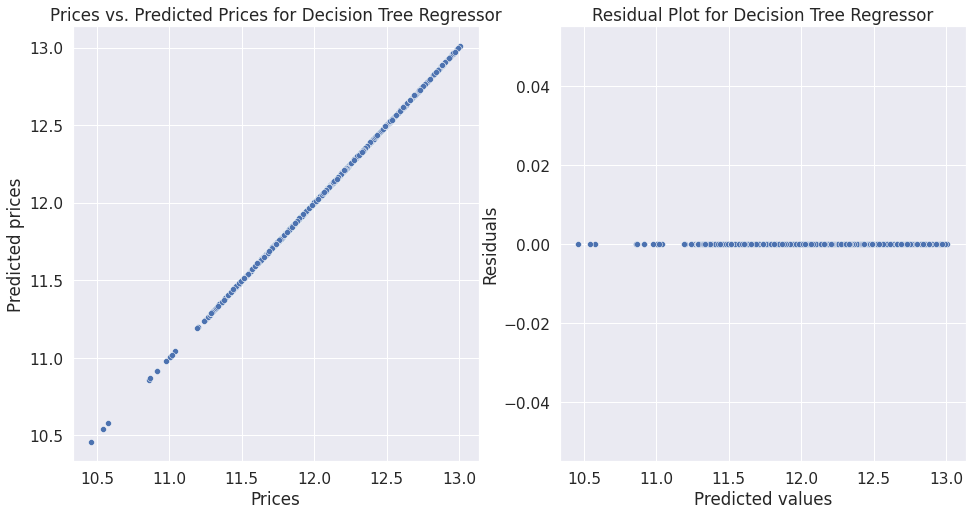

R² for Decision Tree Regressor : 1.0


In [134]:
y_pred = dtreg.predict(X_train)

mae_dtreg = mean_absolute_error(y_train, y_pred)
mse_dtreg = mean_squared_error(y_train, y_pred)
rmse_dtreg = np.sqrt(mse_dtreg)

print(f'Mean absolute error for Decision Tree Regressor : {mae_dtreg:.4f}')
print(f'Mean squared error for Decision Tree Regressor : {mse_dtreg:.4f}')
print(f'Root mean squared error for Decision Tree Regressor : {rmse_dtreg:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for Decision Tree Regressor");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for Decision Tree Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_dtreg = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for Decision Tree Regressor :', r2_dtreg)

## Random Forest Regressor

In [135]:
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1)
grid_rf.fit(X_train, y_train)
pred_rf = grid_rf.predict(test)
# back to normal value using built-in numpy exp() function
pred_rf_log = np.exp(pred_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [136]:
df_sub_rf = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_rf_log})

In [137]:
df_sub_rf.head(20)

Id      SalePrice
0   1461  136851.123541
1   1462  153324.530966
2   1463  175034.894832
3   1464  185419.136663
4   1465  206943.706523
5   1466  183168.887345
6   1467  185590.218838
7   1468  179355.605634
8   1469  194869.699188
9   1470  127540.913623
10  1471  205904.081628
11  1472   93813.555701
12  1473  102330.564060
13  1474  149947.014498
14  1475  162812.299351
15  1476  282587.613007
16  1477  256990.020439
17  1478  300925.483501
18  1479  286799.837901
19  1480  302737.594270

### Model Evaluation 

Mean absolute error for Random Forest Regressor : 0.0506
Mean squared error for Random Forest Regressor : 0.0057
Root mean squared error for Random Forest Regressor : 0.0754


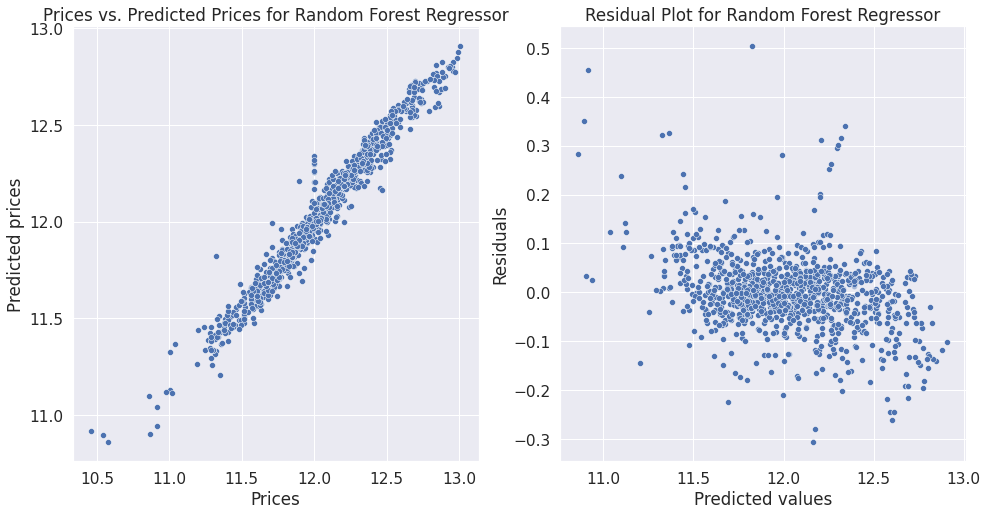

R² for Random Forest Regressor : 0.9602155884499928


In [138]:
y_pred = grid_rf.predict(X_train)

mae_rf = mean_absolute_error(y_train, y_pred)
mse_rf = mean_squared_error(y_train, y_pred)
rmse_rf = np.sqrt(mse_rf)

print(f'Mean absolute error for Random Forest Regressor : {mae_rf:.4f}')
print(f'Mean squared error for Random Forest Regressor : {mse_rf:.4f}')
print(f'Root mean squared error for Random Forest Regressor : {rmse_rf:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for Random Forest Regressor");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for Random Forest Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_rf = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for Random Forest Regressor :', r2_rf)

## K Nearest Neighbors - Regression (KNN)

In [139]:
param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, refit=True, verbose=1)
grid_knn.fit(X_train, y_train)
pred_knn = grid_knn.predict(test)
# back to normal value using built-in numpy exp() function
pred_knn_log = np.exp(pred_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


In [140]:
df_sub_knn = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_knn_log})

In [141]:
df_sub_knn.head(20)

Id      SalePrice
0   1461  172971.571652
1   1462  187610.436370
2   1463  201486.259319
3   1464  182896.912136
4   1465  158476.805586
5   1466  178743.100073
6   1467  172555.102271
7   1468  139202.784252
8   1469  171570.078348
9   1470  153119.790995
10  1471  138182.515077
11  1472   96309.963313
12  1473   95973.389774
13  1474  142620.737857
14  1475  143731.828742
15  1476  197051.491583
16  1477  224829.560569
17  1478  239173.259739
18  1479  273915.782654
19  1480  317572.272924

### Model Evaluation 

Mean absolute error for KNN Regressor : 0.0000
Mean squared error for KNN Regressor : 0.0000
Root mean squared error for KNN Regressor : 0.0000


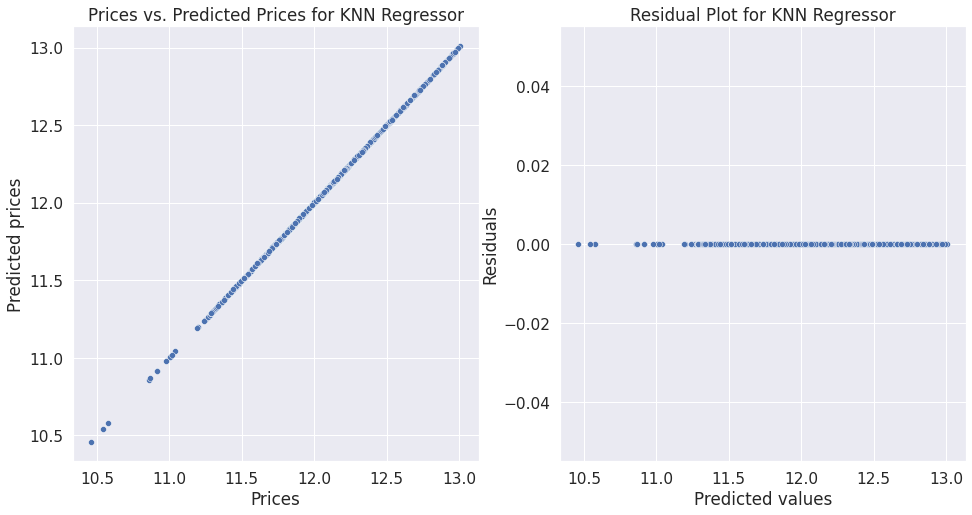

R² for KNN Regressor : 1.0


In [142]:
y_pred = grid_knn.predict(X_train)

mae_knn = mean_absolute_error(y_train, y_pred)
mse_knn = mean_squared_error(y_train, y_pred)
rmse_knn = np.sqrt(mse_knn)

print(f'Mean absolute error for KNN Regressor : {mae_knn:.4f}')
print(f'Mean squared error for KNN Regressor : {mse_knn:.4f}')
print(f'Root mean squared error for KNN Regressor : {rmse_knn:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for KNN Regressor");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for KNN Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_knn = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for KNN Regressor :', r2_knn)

## Gaussian process regression

In [143]:
gpr = GaussianProcessRegressor(random_state=5, alpha=5e-9, 
                                n_restarts_optimizer=0, 
                               optimizer='fmin_l_bfgs_b', 
                               copy_X_train=True)

param_grid = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid_gpr = GridSearchCV(gpr, param_grid, cv=5, verbose=1)
grid_gpr.fit(X_train, y_train)
pred_gpr = grid_gpr.predict(test)
# back to normal value using built-in numpy exp() function
pred_gpr_log = np.exp(pred_gpr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [144]:
df_sub_gpr = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_gpr_log})

In [145]:
df_sub_gpr.head(20)

Id      SalePrice
0   1461  166225.674867
1   1462  166225.674867
2   1463  166225.674867
3   1464  166225.674867
4   1465  166225.674867
5   1466  166225.674867
6   1467  166225.674867
7   1468  166225.674867
8   1469  166225.674867
9   1470  166225.674867
10  1471  166225.674867
11  1472  166225.674867
12  1473  166225.674867
13  1474  166225.674867
14  1475  166225.674867
15  1476  166225.674867
16  1477  166225.674867
17  1478  166225.674867
18  1479  166225.674867
19  1480  166225.674867

### Model Evaluation 

Mean absolute error for Gaussian Process Regressor : 0.2957
Mean squared error for Gaussian Process Regressor : 0.1430
Root mean squared error for Gaussian Process Regressor : 0.3781


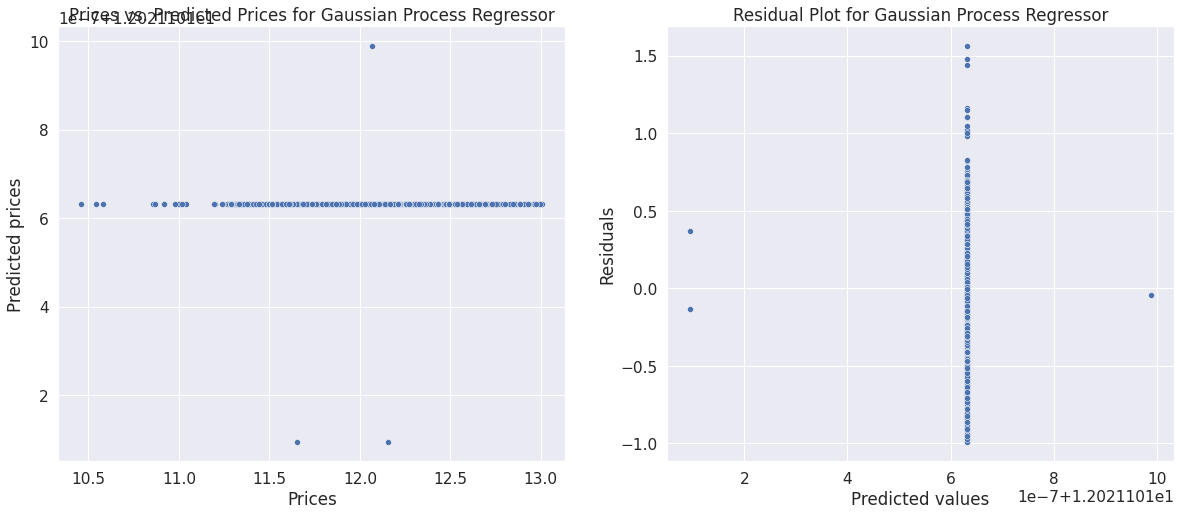

R² for Gaussian Process Regressor : 1.8134627133292724e-09


In [146]:
y_pred = grid_gpr.predict(X_train)

mae_gpr = mean_absolute_error(y_train, y_pred)
mse_gpr = mean_squared_error(y_train, y_pred)
rmse_gpr = np.sqrt(mse_gpr)

print(f'Mean absolute error for Gaussian Process Regressor : {mae_gpr:.4f}')
print(f'Mean squared error for Gaussian Process Regressor : {mse_gpr:.4f}')
print(f'Root mean squared error for Gaussian Process Regressor : {rmse_gpr:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for Gaussian Process Regressor");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for Gaussian Process Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_gpr = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for Gaussian Process Regressor :', r2_gpr)

## LightGBM for Quantile Regression (LightGBM)

In [147]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)
pred_lgb = lgb_model.predict(test)
# back to normal value using built-in numpy exp() function
pred_lgb_log = np.exp(pred_lgb)

In [148]:
df_sub_lgb = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_lgb_log})

In [149]:
df_sub_lgb.head(20)

Id      SalePrice
0   1461  123835.527414
1   1462  152677.852950
2   1463  184635.519104
3   1464  202735.190761
4   1465  203916.783006
5   1466  176206.138627
6   1467  169484.352247
7   1468  162977.128651
8   1469  172896.424211
9   1470  124181.645995
10  1471  193900.781528
11  1472  101615.927407
12  1473  105245.034429
13  1474  147608.013680
14  1475  114072.636864
15  1476  299013.257222
16  1477  242790.505742
17  1478  315069.114699
18  1479  331207.371858
19  1480  281023.849409

### Model Evaluation 

Mean absolute error for LightGBM Regressor : 0.0617
Mean squared error for LightGBM Regressor : 0.0071
Root mean squared error for LightGBM Regressor : 0.0844


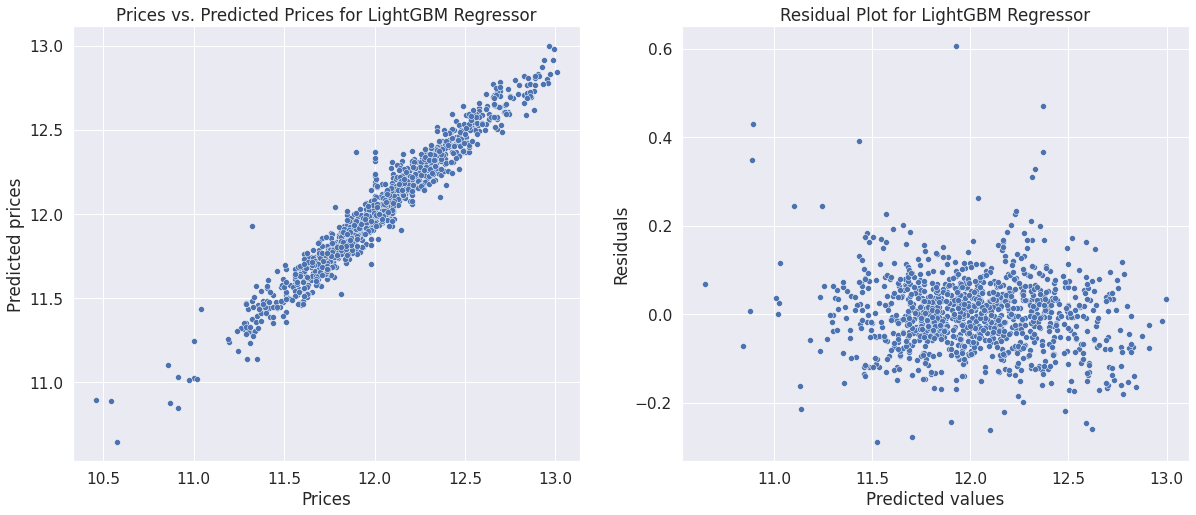

R² for LightGBM Regressor : 0.9501844537569479


In [150]:
y_pred = lgb_model.predict(X_train)

mae_lgb = mean_absolute_error(y_train, y_pred)
mse_lgb = mean_squared_error(y_train, y_pred)
rmse_lgb = np.sqrt(mse_lgb)

print(f'Mean absolute error for LightGBM Regressor : {mae_lgb:.4f}')
print(f'Mean squared error for LightGBM Regressor : {mse_lgb:.4f}')
print(f'Root mean squared error for LightGBM Regressor : {rmse_lgb:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for LightGBM Regressor");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for LightGBM Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_lgb = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for LightGBM Regressor :', r2_lgb)

## XGBoost for Regression (XGB)

In [151]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000], 
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(test)
# back to normal value using built-in numpy exp() function
pred_xgb_log = np.exp(pred_xgb)

[04:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [152]:
df_sub_xgb = pd.DataFrame({'Id': df_test['Id'],'SalePrice':pred_xgb_log})

In [153]:
df_sub_xgb.head(20)

Id      SalePrice
0   1461  126372.992188
1   1462  156703.000000
2   1463  178835.750000
3   1464  200576.890625
4   1465  184210.187500
5   1466  178564.937500
6   1467  162737.421875
7   1468  166048.906250
8   1469  189631.265625
9   1470  120305.562500
10  1471  194553.593750
11  1472   97836.921875
12  1473  110085.492188
13  1474  144326.078125
14  1475  113270.078125
15  1476  310761.781250
16  1477  248044.593750
17  1478  323544.781250
18  1479  320705.312500
19  1480  338294.593750

### Model Evaluation 

Mean absolute error for XGB Regressor : 0.0159
Mean squared error for XGB Regressor  : 0.0004
Root mean squared error for XGB Regressor : 0.0212


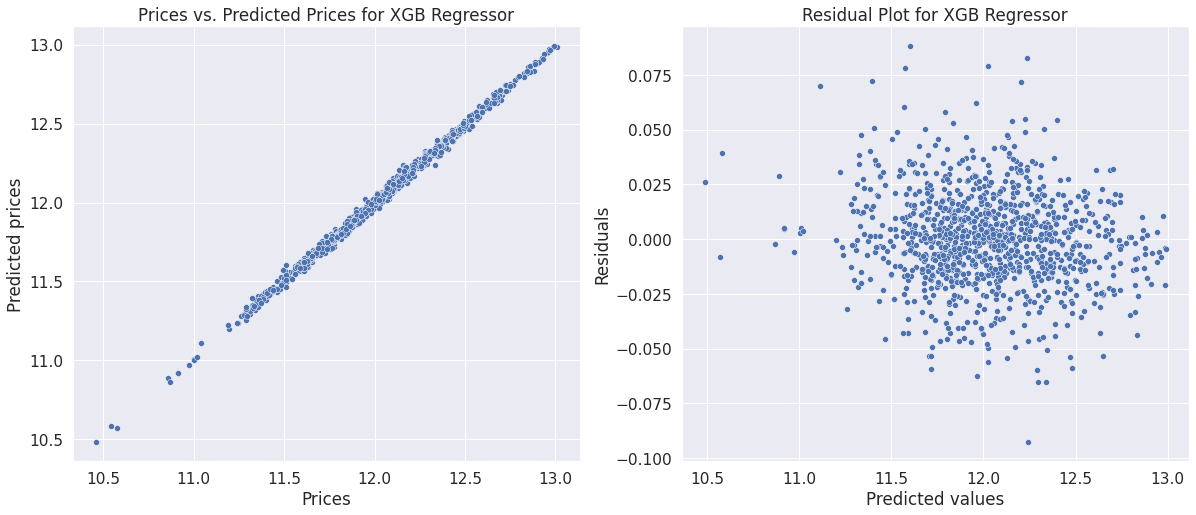

R² for XGB Regressor : 0.9968553656153618


In [154]:
y_pred = xgb_model.predict(X_train)

mae_xgb = mean_absolute_error(y_train, y_pred)
mse_xgb = mean_squared_error(y_train, y_pred)
rmse_xgb = np.sqrt(mse_xgb)

print(f'Mean absolute error for XGB Regressor : {mae_xgb:.4f}')
print(f'Mean squared error for XGB Regressor  : {mse_xgb:.4f}')
print(f'Root mean squared error for XGB Regressor : {rmse_xgb:.4f}')

sns.set(font_scale=1.4)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.scatterplot(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices for XGB Regressor");

plt.subplot(1,2,2)
sns.scatterplot(y_pred, y_pred - y_train)
plt.title("Residual Plot for XGB Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

actual_minus_predicted = sum((y_train - y_pred)**2)
actual_minus_actual_mean = sum((y_train - y_train.mean())**2)
r2_xgb = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R² for XGB Regressor :', r2_xgb)

# Comparison plot: RMSE of all Regression Techniques without SGD 

In [155]:
list_scores_rmse = [rmse_reg, rmse_ridge, rmse_lasso, rmse_elastic_net,
               rmse_dtreg ,rmse_rf, rmse_knn, rmse_gpr,rmse_lgb,rmse_xgb]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','DT' ,'RF','KNN','GPR','LGBM','XGB']

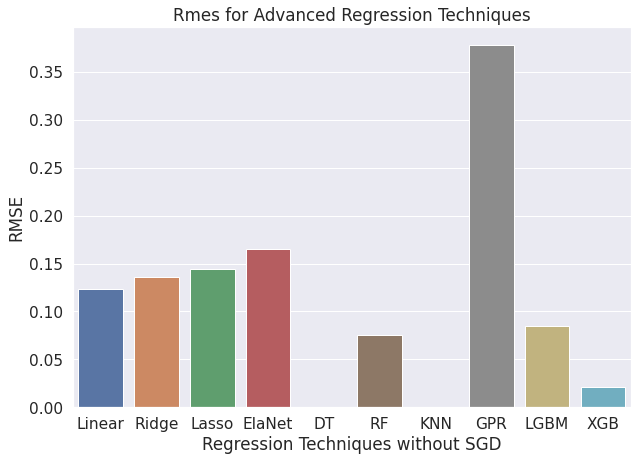

In [156]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores_rmse, ax=ax)
plt.title('Rmes for Advanced Regression Techniques')
plt.xlabel('Regression Techniques without SGD')
plt.ylabel('RMSE')
plt.show()

# Comparison plot: R2 of all Regression Techniques without SGD 

In [157]:
list_scores_r2 = [r2_reg, r2_ridge, r2_lasso, r2_elastic_net,
               r2_dtreg ,r2_rf, r2_knn, r2_gpr,r2_lgb,r2_xgb]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','DT' ,'RF','KNN','GPR','LGBM','XGB']

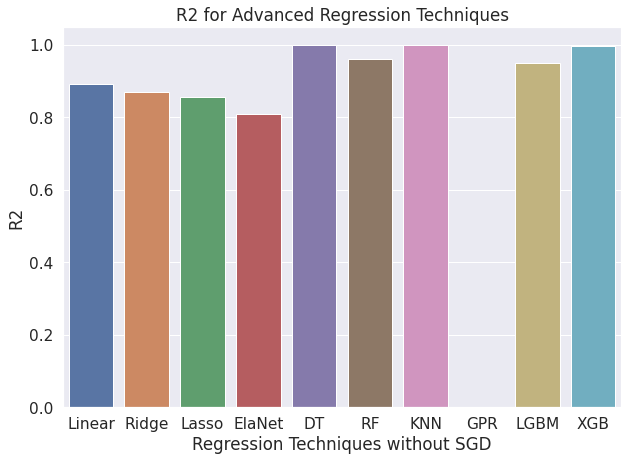

In [158]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores_r2, ax=ax)
plt.title('R2 for Advanced Regression Techniques')
plt.xlabel('Regression Techniques without SGD')
plt.ylabel('R2')
plt.show()

# Correlation of model results

In [159]:
predictions = {'Linear': pred_regressor, 'Ridge': pred_ridge,
               'Lasso': pred_lasso,'ElaNet': pred_enet, 'SGD': pred_sgd,
               'DT': pred_dtr,'RF': pred_rf,'KNN': pred_knn, 'GPR': pred_gpr,
               'LGBM' : pred_lgb, 'XGB': pred_xgb}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

Linear     Ridge     Lasso    ElaNet       SGD        DT        RF  \
Linear  1.000000  0.983172  0.968287  0.944920 -0.375471  0.841272  0.925846   
Ridge   0.983172  1.000000  0.981356  0.960563 -0.375553  0.857535  0.945961   
Lasso   0.968287  0.981356  1.000000  0.985483 -0.366749  0.863500  0.952725   
ElaNet  0.944920  0.960563  0.985483  1.000000 -0.388144  0.860147  0.953077   
SGD    -0.375471 -0.375553 -0.366749 -0.388144  1.000000 -0.327552 -0.366163   
DT      0.841272  0.857535  0.863500  0.860147 -0.327552  1.000000  0.909849   
RF      0.925846  0.945961  0.952725  0.953077 -0.366163  0.909849  1.000000   
KNN     0.705810  0.729170  0.725530  0.743335 -0.588666  0.678629  0.752411   
GPR     0.028709  0.031456  0.024666  0.020838  0.091399  0.039320  0.038289   
LGBM    0.955189  0.969750  0.975238  0.960691 -0.365559  0.875404  0.967459   
XGB     0.951024  0.963521  0.966379  0.953511 -0.357567  0.874712  0.967087   

             KNN       GPR      LGBM       XGB  
Linear  0.705810  0.028709  0.955189  0.951024  
Ridge   0.729170  0.031456  0.969750  0.963521  
Lasso   0.725530  0.024666  0.975238  0.966379  
ElaNet  0.743335  0.020838  0.960691  0.953511  
SGD    -0.588666  0.091399 -0.365559 -0.357567  
DT      0.678629  0.039320  0.875404  0.874712  
RF      0.752411  0.038289  0.967459  0.967087  
KNN     1.000000  0.012754  0.735115  0.742865  
GPR     0.012754  1.000000  0.028153  0.022810  
LGBM    0.735115  0.028153  1.000000  0.988357  
XGB     0.742865  0.022810  0.988357  1.000000

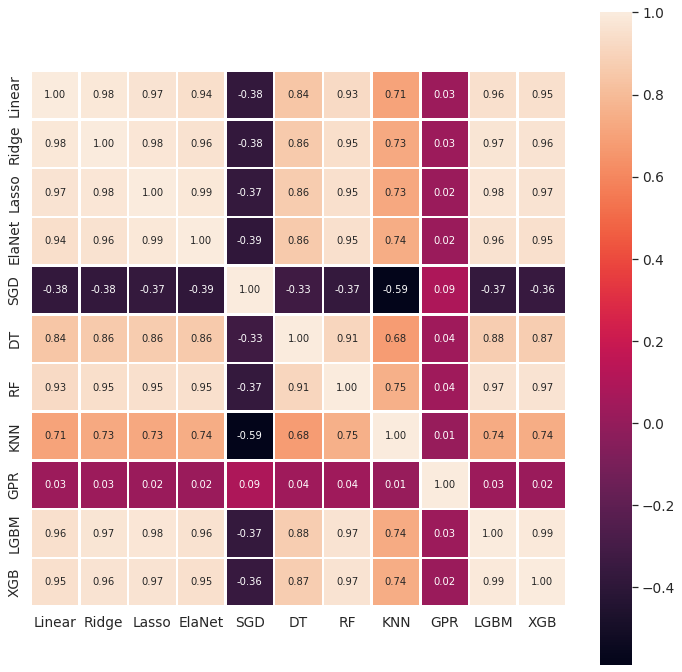

In [160]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.show()

# mean of best models

In [161]:
sub_mean = pd.DataFrame()
sub_mean['Id'] = df_test['Id']
sub_mean['SalePrice'] = ( pred_regressor + pred_ridge + pred_lasso+
                         pred_enet + pred_dtr + pred_rf +
                         pred_knn  + pred_lgb + pred_xgb )/9.0
sub_mean_log = np.exp(sub_mean['SalePrice'] )
sub_mean_all = pd.DataFrame({'Id': df_test['Id'],'SalePrice':sub_mean_log})
sub_mean_all.head(20)

Id      SalePrice
0   1461  130604.863758
1   1462  142831.325681
2   1463  178475.178596
3   1464  194240.149218
4   1465  186651.345860
5   1466  176685.019402
6   1467  178423.531737
7   1468  164841.331927
8   1469  178339.093861
9   1470  131341.873520
10  1471  188674.560288
11  1472   99836.839077
12  1473  101997.499139
13  1474  146174.995686
14  1475  129582.332917
15  1476  285053.089300
16  1477  247517.205859
17  1478  289290.522629
18  1479  292912.745050
19  1480  327765.481820

In [162]:
df_submission = sub_mean_all.to_csv("My_submission.csv", header=True, index=False)

In [163]:
df_submission